# Example - Building Permits

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-target" data-toc-modified-id="Create-a-target-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a target</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Domain classifier</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from models.aux_functions import *

np.random.seed(42)

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
DATASETS_PATH = "~/Documents/datasets/sf_building_permits/"
PREFIX = "building_permits"

In [5]:
data = pd.read_csv(DATASETS_PATH + "Building_Permits.csv", engine="python")

In [7]:
data.shape

(198900, 43)

In [8]:
data.nunique()

Permit Number                             181495
Permit Type                                    8
Permit Type Definition                         8
Permit Creation Date                        1291
Block                                       4896
Lot                                         1055
Street Number                               5099
Street Number Suffix                          18
Street Name                                 1704
Street Suffix                                 21
Unit                                         660
Unit Suffix                                  164
Description                               134272
Current Status                                14
Current Status Date                         1307
Filed Date                                  1288
Issued Date                                 1289
Completed Date                              1300
First Construction Document Date            1288
Structural Notification                        1
Number of Existing S

In [9]:
data.dtypes

Permit Number                              object
Permit Type                                 int64
Permit Type Definition                     object
Permit Creation Date                       object
Block                                      object
Lot                                        object
Street Number                               int64
Street Number Suffix                       object
Street Name                                object
Street Suffix                              object
Unit                                      float64
Unit Suffix                                object
Description                                object
Current Status                             object
Current Status Date                        object
Filed Date                                 object
Issued Date                                object
Completed Date                             object
First Construction Document Date           object
Structural Notification                    object


In [10]:
print(data["Permit Creation Date"].min())
print(data["Permit Creation Date"].max())

01/02/2013
12/31/2015


In [11]:
data["Permit Creation Date"] = pd.to_datetime(data["Permit Creation Date"])

In [12]:
data["Year"] = data["Permit Creation Date"].apply(lambda x: int(x.year))

## Create a target

Let's create if the animal was adopted in the following 6 months.

In [13]:
data["Site Permit"].unique()

array([nan, 'Y'], dtype=object)

In [14]:
data["target"] = (data["Site Permit"] == "Y").astype(int)

In [15]:
data["target"].mean()

0.026943187531422826

## Modeling

### Data

In [16]:
TIME_COLUMN = "Year"
TARGET = "target"

In [17]:
columns_to_label_encode = ["Street Suffix", 
                           "Proposed Use",
                           "Unit Suffix",
                           "Fire Only Permit",
                           "Existing Use",
                           "Neighborhoods - Analysis Boundaries"]

In [18]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

Street Suffix
Proposed Use


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Unit Suffix
Fire Only Permit
Existing Use
Neighborhoods - Analysis Boundaries


In [19]:
numerical_features = ["Number of Existing Stories",
                      "Number of Proposed Stories",
                      "Supervisor District",
                      "Plansets",
                      "Estimated Cost",
                      "Existing Units",
                      "Proposed Units",
                      "Proposed Construction Type",
                      "Existing Construction Type"]

In [20]:
features = columns_to_label_encode + numerical_features
features = list(set(features))

In [21]:
data["Year"].value_counts()

2017    41156
2015    40150
2016    39721
2014    36686
2013    35228
2018     5937
2012       22
Name: Year, dtype: int64

In [22]:
data = data[~data["Year"].isin([2012])]

In [23]:
data["Year"].value_counts()

2017    41156
2015    40150
2016    39721
2014    36686
2013    35228
2018     5937
Name: Year, dtype: int64

In [30]:
data["Year"].max()

2021

In [24]:
training_start_year = 2013
training_end_year = 2015
holdout_end_year = 2018

In [25]:
in_time = data[data["Year"] <= training_end_year]
in_time = in_time[in_time["Year"] >= training_start_year]
out_of_time = data[data["Year"] > training_end_year]

In [26]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [27]:
train.shape

(89651, 45)

In [28]:
test.shape

(22413, 45)

In [29]:
out_of_time.shape

(86814, 45)

In [30]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Checking the support in the different environments

In [31]:
check_categoricals_match(train, columns_to_label_encode, "Year")

Year
2013    0.9
2014    0.9
2015    0.9
Name: Street Suffix, dtype: float64
Year
2013    0.872340
2014    0.893617
2015    0.797872
Name: Proposed Use, dtype: float64
Year
2013    0.620370
2014    0.509259
2015    0.546296
Name: Unit Suffix, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Fire Only Permit, dtype: float64
Year
2013    0.880435
2014    0.880435
2015    0.815217
Name: Existing Use, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Neighborhoods - Analysis Boundaries, dtype: float64


0.8619912594267616

In [33]:
check_numerical_match(train, numerical_features, TIME_COLUMN, verbose=True, n_q=10)

Year
2013    0.9
2014    0.9
2015    0.9
Name: Number of Existing Stories_quant, dtype: float64
Year
2013    0.9
2014    1.0
2015    0.9
Name: Number of Proposed Stories_quant, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Supervisor District_quant, dtype: float64
Year
2013    0.5
2014    0.5
2015    1.0
Name: Plansets_quant, dtype: float64
Year
2013    0.500
2014    0.625
2015    0.750
Name: Estimated Cost_quant, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Existing Units_quant, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Proposed Units_quant, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Proposed Construction Type_quant, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Existing Construction Type_quant, dtype: float64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.9027777777777778

### Benchmark

In [34]:
from pycaret.classification import *

In [35]:
clf1 = setup(train[features + [TARGET]], 
             target="target",
             session_id=1, 
             log_experiment=False, 
             experiment_name="{}".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

In [36]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=7, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=-1,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [37]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [38]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt"]))

0.9741661002171386
0.9705991249737367
0.9592654779784598


In [39]:
benchmark_model = RandomForestClassifier(n_estimators=250, max_depth=8)
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [40]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

0.9732755255331689
0.967201846271264
0.9570064017011942


In [41]:
benchmark_importances = benchmark_model.feature_importances_
benchmark_importances = pd.Series(benchmark_importances, index=features)
benchmark_importances.rename("RF", inplace=True)

Plansets                               0.121009
Existing Construction Type             0.022328
Existing Use                           0.096325
Proposed Construction Type             0.014575
Street Suffix                          0.025314
Unit Suffix                            0.000278
Supervisor District                    0.022070
Number of Existing Stories             0.040433
Estimated Cost                         0.462709
Number of Proposed Stories             0.041202
Fire Only Permit                       0.006206
Proposed Units                         0.027979
Existing Units                         0.033012
Neighborhoods - Analysis Boundaries    0.024370
Proposed Use                           0.062192
Name: RF, dtype: float64

In [42]:
results = reverse_learning_curve(train, out_of_time, benchmark_model, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5)

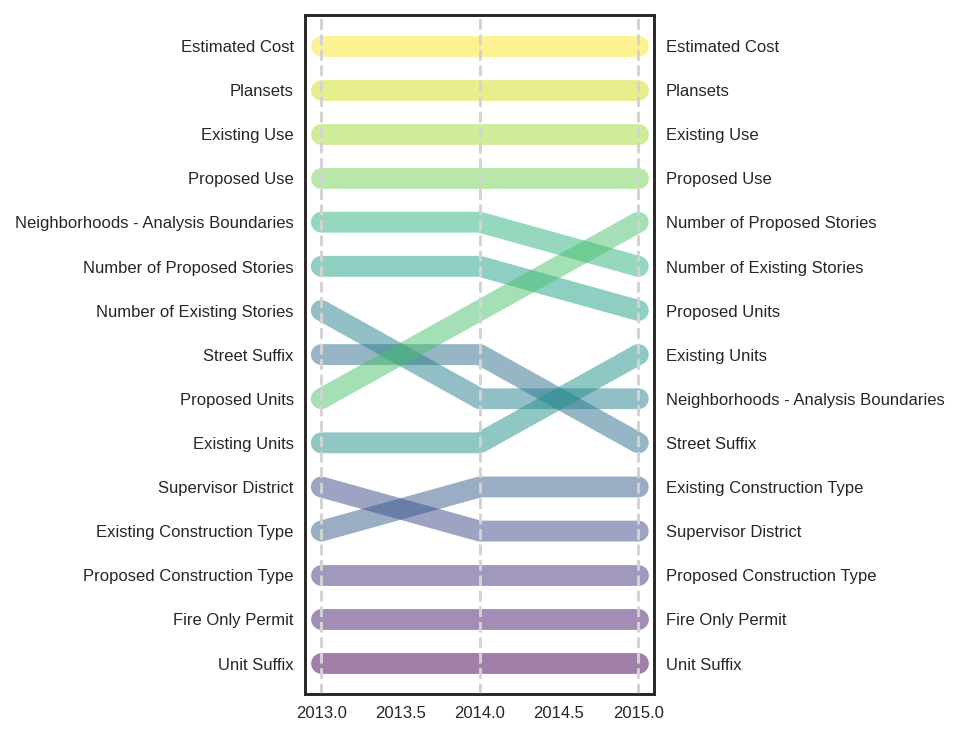

In [43]:
importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, features, 
                                                                                             save_as="../images/{}_benchmark_importance_migration_learning_curve.eps".format(PREFIX))

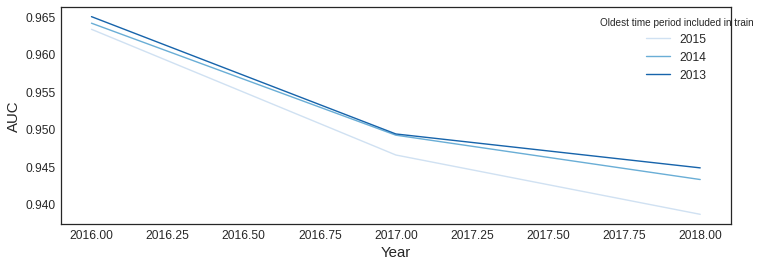

In [44]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [45]:
results

{'round': [],
 'holdout_performance': [0.9547459644464651,
  0.9565972471539215,
  0.9571868513013416],
 'feature_importance': [Plansets                               0.203558
  Existing Construction Type             0.017879
  Existing Use                           0.074729
  Proposed Construction Type             0.012341
  Street Suffix                          0.036696
  Unit Suffix                            0.000283
  Supervisor District                    0.028356
  Number of Existing Stories             0.036980
  Estimated Cost                         0.362073
  Number of Proposed Stories             0.043341
  Fire Only Permit                       0.003981
  Proposed Units                         0.034583
  Existing Units                         0.034241
  Neighborhoods - Analysis Boundaries    0.051525
  Proposed Use                           0.059434
  Name: 2015, dtype: float64,
  Plansets                               0.138989
  Existing Construction Type             0.0

## Challenger model

In [46]:
train.reset_index(drop=True, inplace=True)

In [47]:
train[features + [TIME_COLUMN]]

Plansets  Existing Construction Type  Existing Use  \
0           2.0                         5.0             1   
1           0.0                         5.0             0   
2           2.0                         5.0            88   
3           2.0                         5.0            72   
4           2.0                         5.0             2   
...         ...                         ...           ...   
89646       2.0                         5.0             0   
89647       0.0                         5.0             0   
89648       2.0                         3.0             9   
89649       0.0                         5.0             0   
89650       2.0                         5.0             1   

       Proposed Construction Type  Street Suffix  Unit Suffix  \
0                             5.0              1          107   
1                             5.0             17          107   
2                             5.0             17          107   
3                             5.0             17          107   
4                             5.0             17          107   
...                           ...            ...          ...   
89646                         5.0             17          107   
89647                         5.0              5          107   
89648                         3.0              1          107   
89649                         5.0             17          107   
89650                         5.0             17          107   

       Supervisor District  Number of Existing Stories  Estimated Cost  \
0                      9.0                         3.0           100.0   
1                      8.0                         2.0         10000.0   
2                      6.0                         3.0          5000.0   
3                      8.0                         3.0           500.0   
4                      3.0                         3.0         10000.0   
...                    ...                         ...             ...   
89646                  2.0                         3.0             1.0   
89647                  7.0                         2.0          3500.0   
89648                  2.0                         7.0          6500.0   
89649                  2.0                         2.0          4800.0   
89650                  8.0                         3.0             1.0   

       Number of Proposed Stories  Fire Only Permit  Proposed Units  \
0                             3.0                 0             2.0   
1                             2.0                 0             1.0   
2                             4.0                 1             2.0   
3                             3.0                 0             1.0   
4                             3.0                 0             1.0   
...                           ...               ...             ...   
89646                         3.0                 0             1.0   
89647                         2.0                 0             1.0   
89648                         7.0                 0            64.0   
89649                         2.0                 0             1.0   
89650                         3.0                 0             2.0   

       Existing Units  Neighborhoods - Analysis Boundaries  Proposed Use  Year  
0                 2.0                                   18             1  2015  
1                 1.0                                    2             0  2014  
2                 1.0                                   34             1  2014  
3                 1.0                                    2             2  2015  
4                 1.0                                   23             2  2015  
...               ...                                  ...           ...   ...  
89646             1.0                                   31             0  2015  
89647             1.0                                   40             0  2015  
89648            64.0 

In [48]:
train["Year"].value_counts()

2015    32182
2014    29331
2013    28138
Name: Year, dtype: int64

In [50]:
CHALLENGER_MAX_DEPTH = 7
CHALLENGER_N_ESTIMATORS = 90
CHALLENGER_MIN_SAMPLES_BY_PERIODS = 2

In [51]:
challenger_model_max = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        period_criterion='max',
                                        multi=True)

challenger_model_max.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

In [52]:
train["challenger_prediction_max"] = challenger_model_max.predict_proba(train[features])[:, 1]
test["challenger_prediction_max"] = challenger_model_max.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction_max"] = challenger_model_max.predict_proba(out_of_time[features])[:, 1]

In [53]:
print(roc_auc_score(train[TARGET], train["challenger_prediction_max"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction_max"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction_max"]))

0.9662152168194489
0.9630458427343346
0.9549287798837041


In [54]:
challenger_model_max.feature_importance()

challenger_model_max_importances = challenger_model_max.feature_importance()
challenger_model_max_importances.rename("TRF Max", inplace=True)

Estimated Cost                         1143
Existing Use                            762
Number of Proposed Stories              550
Neighborhoods - Analysis Boundaries     541
Proposed Use                            529
Number of Existing Stories              527
Supervisor District                     526
Proposed Units                          482
Street Suffix                           430
Existing Units                          347
Plansets                                334
Existing Construction Type              319
Proposed Construction Type              272
Fire Only Permit                        125
Unit Suffix                              74
Name: TRF Max, dtype: int64

In [56]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)
challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

In [57]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

0.9669246315536508
0.9637497392219795
0.956130387714321


## Feature Importance migration

In [58]:
challenger_model_importances = challenger_model.feature_importance()
challenger_model_importances.rename("TRF", inplace=True)
all_models_importance = pd.DataFrame(index=features)
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_max_importances, how="left", left_index=True, 
                            right_index=True)

all_models_importance.fillna(0, inplace=True)
all_models_importance

RF   TRF  TRF Max
Plansets                             0.121009   341      334
Existing Construction Type           0.022328   296      319
Existing Use                         0.096325   740      762
Proposed Construction Type           0.014575   276      272
Street Suffix                        0.025314   451      430
Unit Suffix                          0.000278    68       74
Supervisor District                  0.022070   569      526
Number of Existing Stories           0.040433   519      527
Estimated Cost                       0.462709  1113     1143
Number of Proposed Stories           0.041202   550      550
Fire Only Permit                     0.006206   109      125
Proposed Units                       0.027979   533      482
Existing Units                       0.033012   390      347
Neighborhoods - Analysis Boundaries  0.024370   497      541
Proposed Use                         0.062192   516      529

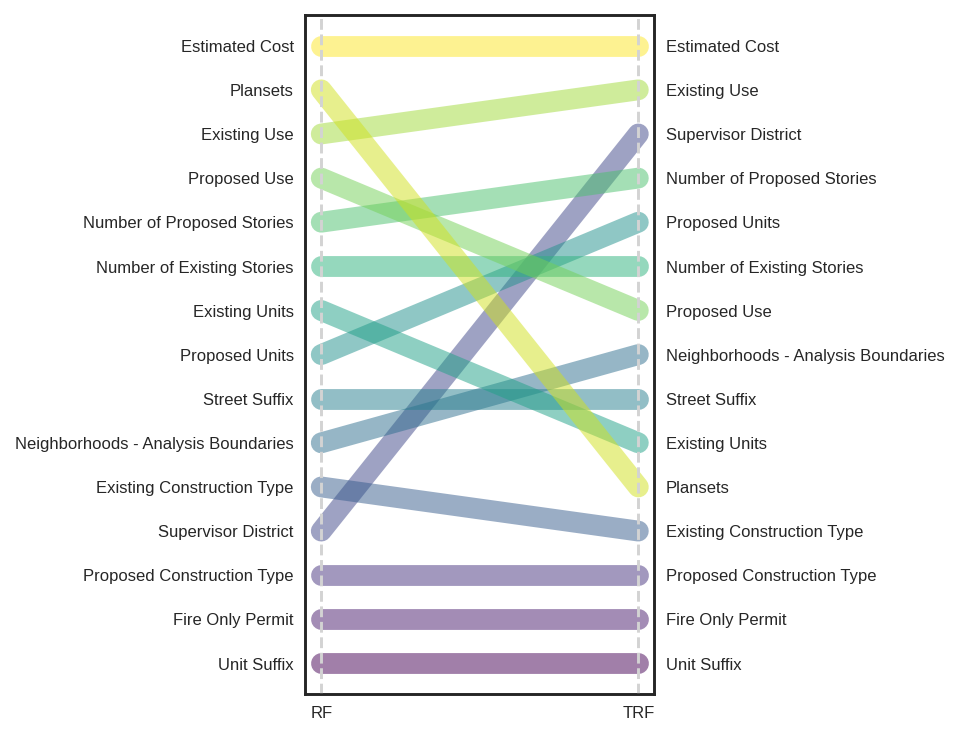

In [59]:
plot_shap_difference(all_models_importance[["RF", "TRF"]], title="", save_as="../images/{}_importance_migration.eps".format(PREFIX))

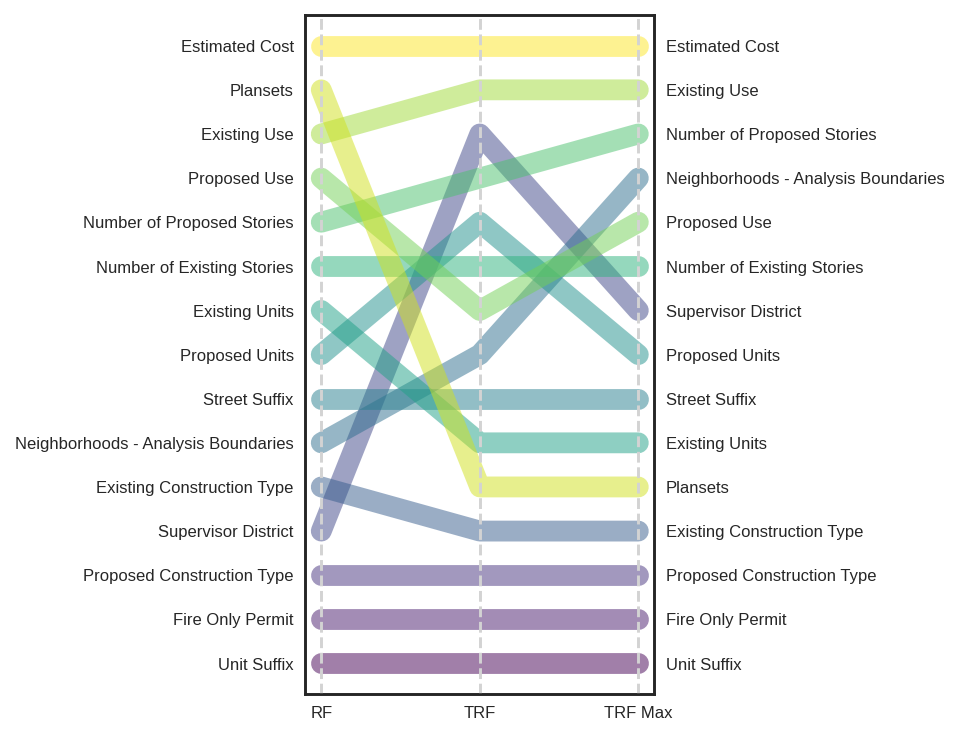

In [60]:
plot_shap_difference(all_models_importance, title="", save_as="../images/{}_importance_migration_trf_max.eps".format(PREFIX))

## Reverse Learning Curve

In [61]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)

In [62]:
results_trt = reverse_learning_curve(train, out_of_time, challenger_model, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5, trt_model=True)

2015  2014  2013
Plansets                              432   333   310
Existing Construction Type            307   321   319
Existing Use                          613   724   789
Proposed Construction Type            223   271   264
Street Suffix                         415   460   451
Unit Suffix                            61    81    83
Supervisor District                   436   495   488
Number of Existing Stories            491   518   543
Estimated Cost                        986  1067  1050
Number of Proposed Stories            458   504   518
Fire Only Permit                      141   149   132
Proposed Units                        481   460   482
Existing Units                        405   392   416
Neighborhoods - Analysis Boundaries   444   483   527
Proposed Use                          378   469   502

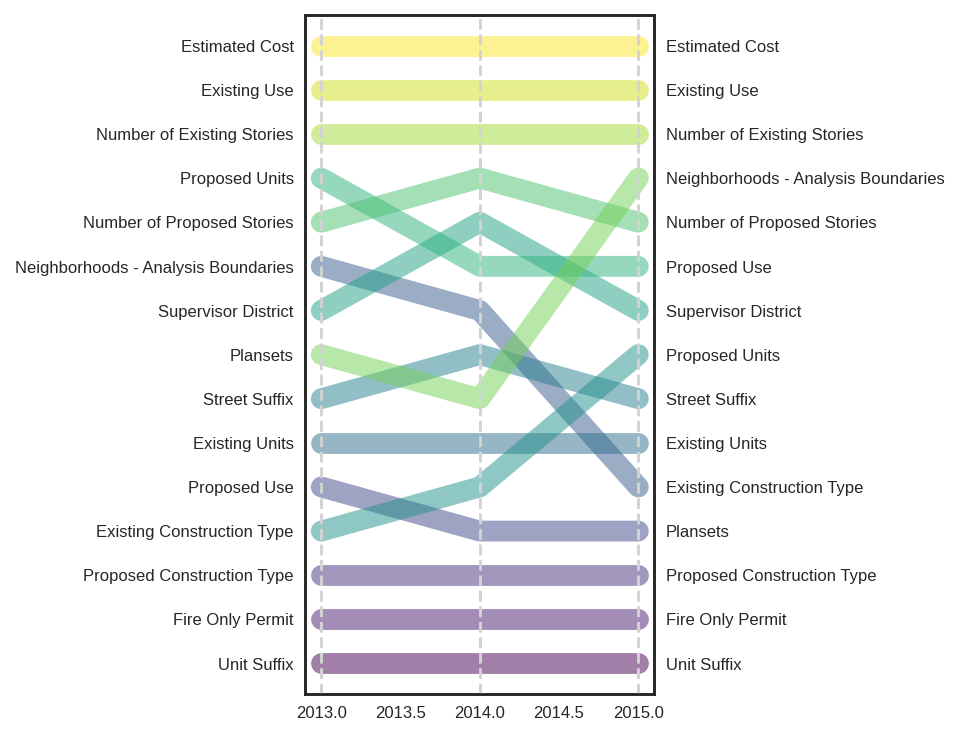

In [63]:
importance_by_reverse_segment_challenger = plot_feature_migration_from_learning_curve_results(results_trt, features, 
                                                                                             save_as="../images/{}_challenger_importance_migration_learning_curve.eps".format(PREFIX))
importance_by_reverse_segment_challenger

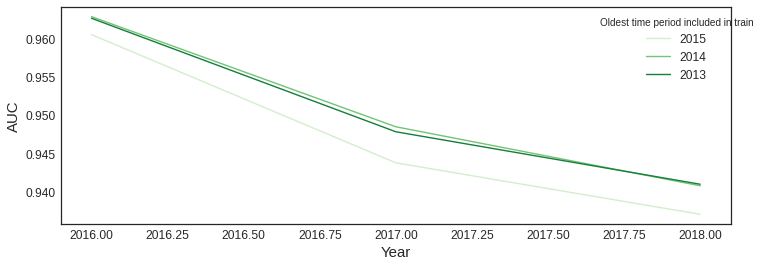

In [64]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

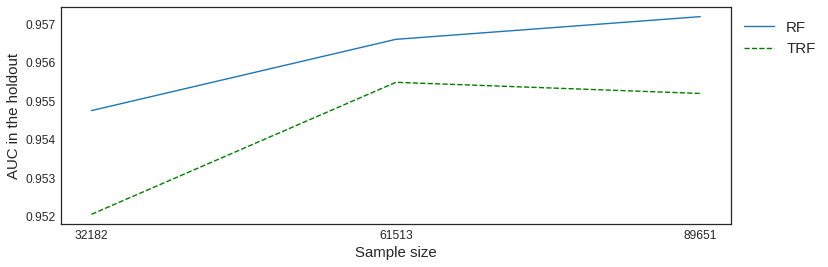

In [65]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_sample.eps".format(PREFIX), format="eps")
plt.show()

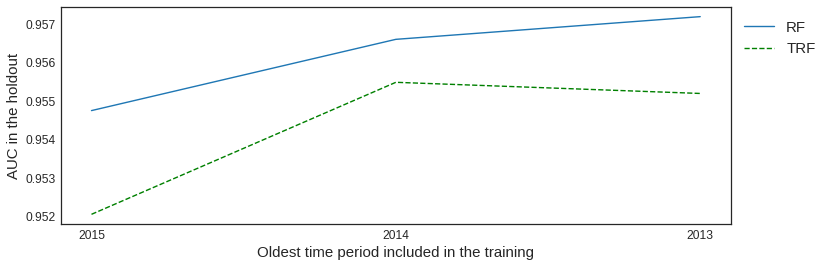

In [66]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_segments.eps".format(PREFIX), format="eps")
plt.show()

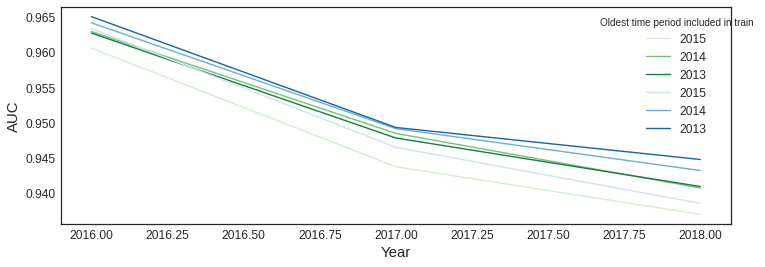

In [67]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))
    
for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_both.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

## Performance comparison

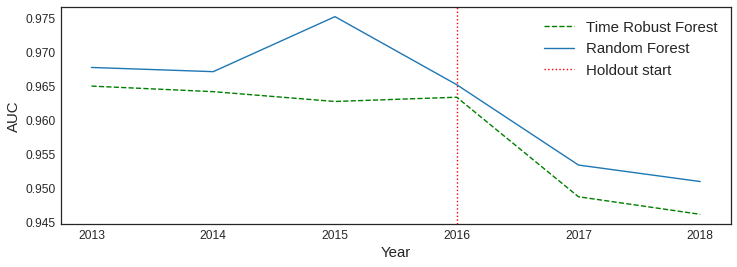

In [68]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_test_holdout_auc_years.eps".format(PREFIX), format="eps")
plt.show()

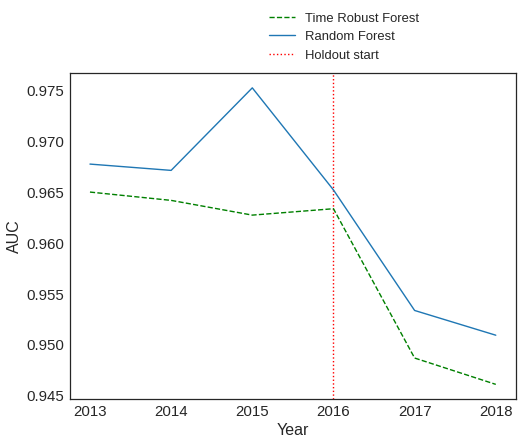

In [69]:
plt.rcParams['figure.figsize'] = (8, 6)
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=13, bbox_to_anchor=(0.42, 1.0))

plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square.eps".format(PREFIX), format="eps")
plt.show()

## TRF as feature selection

In [70]:
challenger_model.feature_importance()

Estimated Cost                         1050
Existing Use                            789
Number of Existing Stories              543
Neighborhoods - Analysis Boundaries     527
Number of Proposed Stories              518
Proposed Use                            502
Supervisor District                     488
Proposed Units                          482
Street Suffix                           451
Existing Units                          416
Existing Construction Type              319
Plansets                                310
Proposed Construction Type              264
Fire Only Permit                        132
Unit Suffix                              83
Name: Feature Importance, dtype: int64

In [71]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance().index]
selected_features

['Plansets',
 'Existing Construction Type',
 'Existing Use',
 'Proposed Construction Type',
 'Street Suffix',
 'Unit Suffix',
 'Supervisor District',
 'Number of Existing Stories',
 'Estimated Cost',
 'Number of Proposed Stories',
 'Fire Only Permit',
 'Proposed Units',
 'Existing Units',
 'Neighborhoods - Analysis Boundaries',
 'Proposed Use']

In [72]:
if len(selected_features) == len(features):
    selected_features = list(challenger_model.feature_importance().sort_values(ascending=False).index[:int(len(features)/2)+2].values)
    
selected_features    

['Estimated Cost',
 'Existing Use',
 'Number of Existing Stories',
 'Neighborhoods - Analysis Boundaries',
 'Number of Proposed Stories',
 'Proposed Use',
 'Supervisor District',
 'Proposed Units',
 'Street Suffix']

In [73]:
selected_features

['Estimated Cost',
 'Existing Use',
 'Number of Existing Stories',
 'Neighborhoods - Analysis Boundaries',
 'Number of Proposed Stories',
 'Proposed Use',
 'Supervisor District',
 'Proposed Units',
 'Street Suffix']

In [74]:
clf1 = setup(train[selected_features + [TARGET]], 
             target="target",
             session_id=3, 
             log_experiment=False, 
             experiment_name="{}_fs".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

In [75]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=-1, oob_score=False,
                       random_state=3, verbose=0, warm_start=False)

In [76]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [77]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

0.9784392286888981
0.9596582156027296
0.9358413138926123


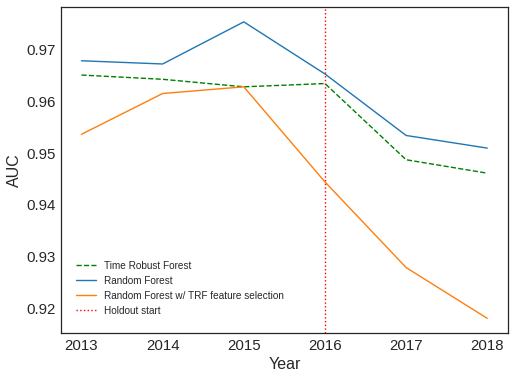

In [78]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="Random Forest w/ TRF feature selection", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=10, bbox_to_anchor=(0.52, 0.25))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square_fs.eps".format(PREFIX), format="eps")
plt.show()

## Feature Impact

In [79]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import PolyCollection as p

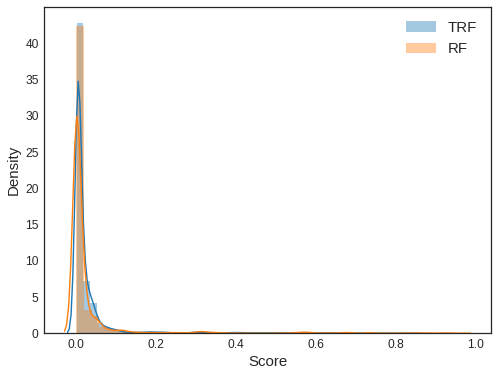

In [80]:
fig, ax = plt.subplots()

sns.distplot(out_of_time["challenger_prediction"], label="TRF")
sns.distplot(out_of_time["benchmark_prediction_opt"], label="RF")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Density", fontsize=15)
plt.xlabel("Score", fontsize=15)

__file__ = "../images/{}_trf_rf_score_distribution".format(PREFIX)
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

ax.set_rasterized(True)
plt.savefig(__file__+".eps")        

plt.savefig("../images/{}_trf_rf_score_distribution.eps".format(PREFIX), format="eps")
plt.show()

In [81]:
ss = StandardScaler()
out_of_time["challenger_prediction_norm"] = ss.fit_transform(out_of_time[["challenger_prediction"]])
out_of_time["benchmark_prediction_norm"] = ss.fit_transform(out_of_time[["benchmark_prediction_opt"]])

<AxesSubplot:xlabel='benchmark_prediction_norm', ylabel='Density'>

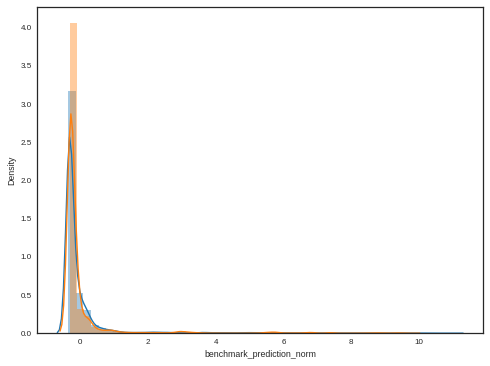

In [82]:
sns.distplot(out_of_time["challenger_prediction_norm"])
sns.distplot(out_of_time["benchmark_prediction_norm"])

In [123]:
X_train, X_test, y_train, y_test = train_test_split(out_of_time[features], 
                                                    out_of_time[["challenger_prediction", 
                                                                 "benchmark_prediction"]],
                                                    test_size=0.6,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(34725, 15)
(52089, 15)


In [124]:
numerical_features = [feature for feature in features if feature not in columns_to_label_encode]
numerical_features

['Plansets',
 'Existing Construction Type',
 'Proposed Construction Type',
 'Supervisor District',
 'Number of Existing Stories',
 'Estimated Cost',
 'Number of Proposed Stories',
 'Proposed Units',
 'Existing Units']

In [125]:
p99 = X_train[numerical_features].quantile(.99)
p01 = X_train[numerical_features].quantile(.01)
p005 = X_train.quantile(.005)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] < p99, other=p99, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] < p99, other=p99, axis=1)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] > p01, other=p01, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] > p01, other=p01, axis=1)

X_train = X_train.fillna(p005)
X_test = X_test.fillna(p005)

In [127]:
dtype = ["numerical" if feature not in columns_to_label_encode else "categorical" for feature in features]

gam_challenger = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["challenger_prediction"].values)
gam_benchmark = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["benchmark_prediction"].values)

100% (11 of 11) |########################| Elapsed Time: 0:00:23 Time:  0:00:23
100% (11 of 11) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


In [129]:
pred_test = gam_challenger.predict(X_test[features])
print("r2 test (challenger): %f" %r2_score(y_test["challenger_prediction"], pred_test))

pred_test = gam_benchmark.predict(X_test[features])
print("r2 test (benchmark): %f" %r2_score(y_test["benchmark_prediction"], pred_test))

r2 test (challenger): 0.584363
r2 test (benchmark): 0.568328


Plansets
0


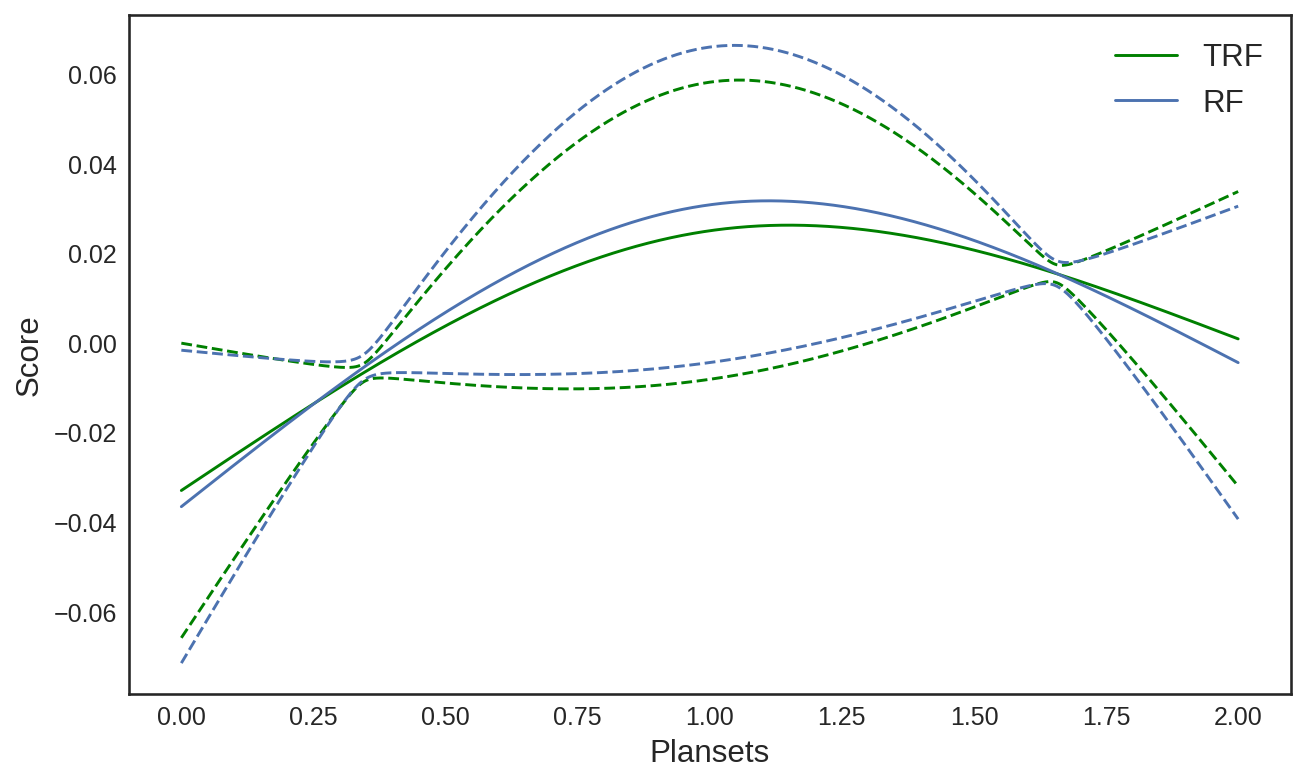

Existing Construction Type
1


<Figure size 576x432 with 0 Axes>

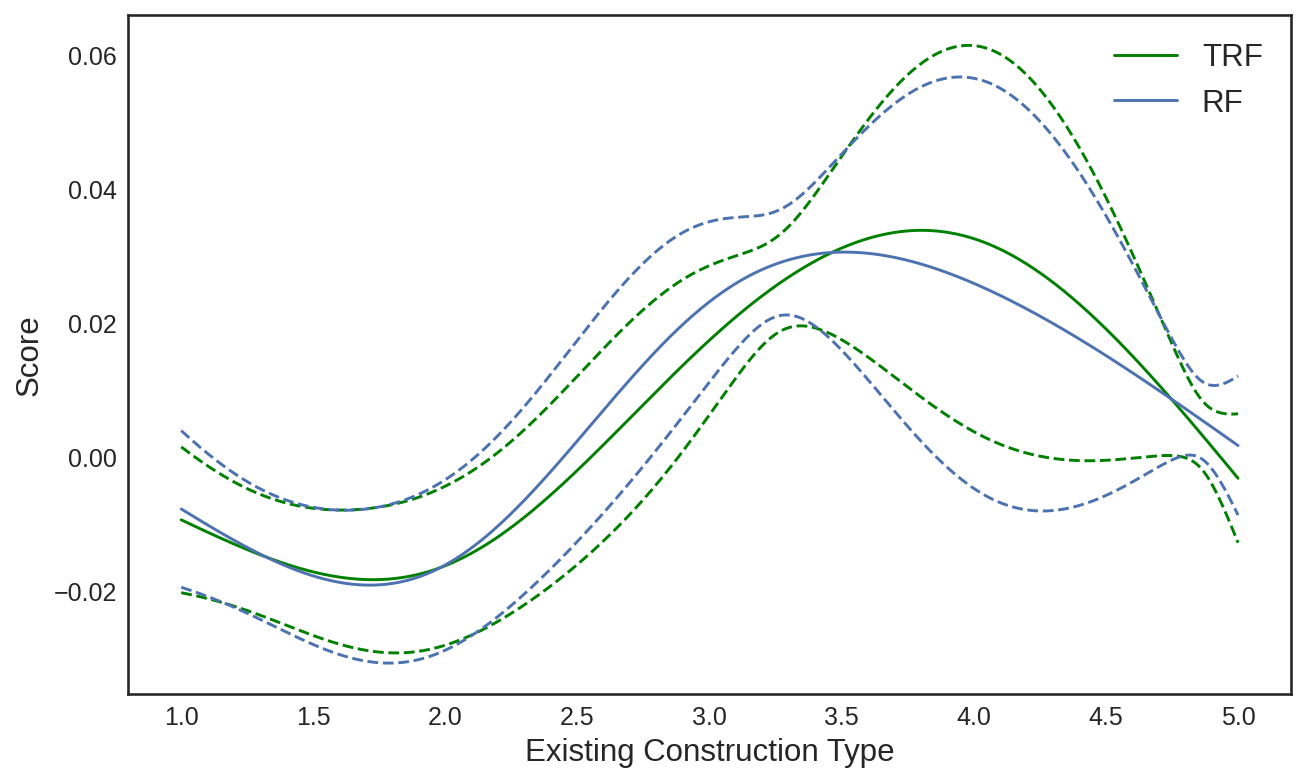

Proposed Construction Type
3


<Figure size 576x432 with 0 Axes>

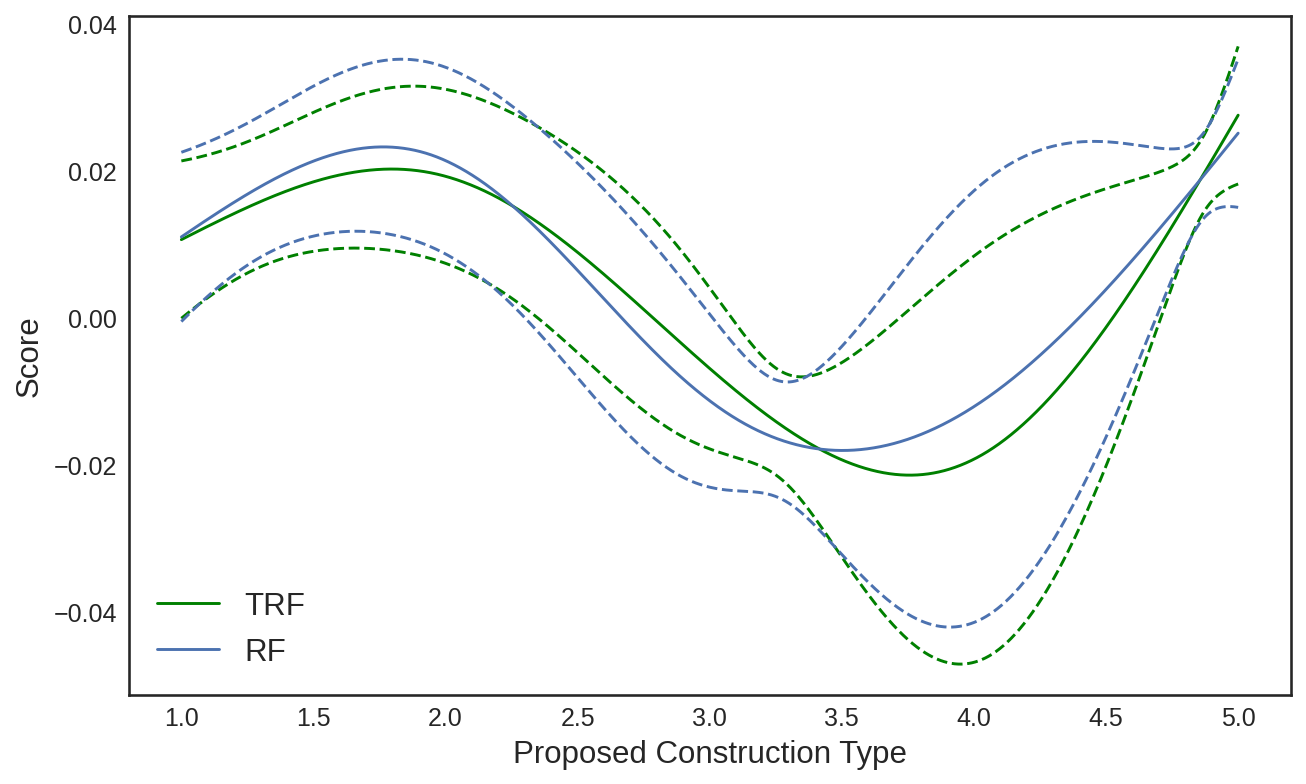

Supervisor District
6


<Figure size 576x432 with 0 Axes>

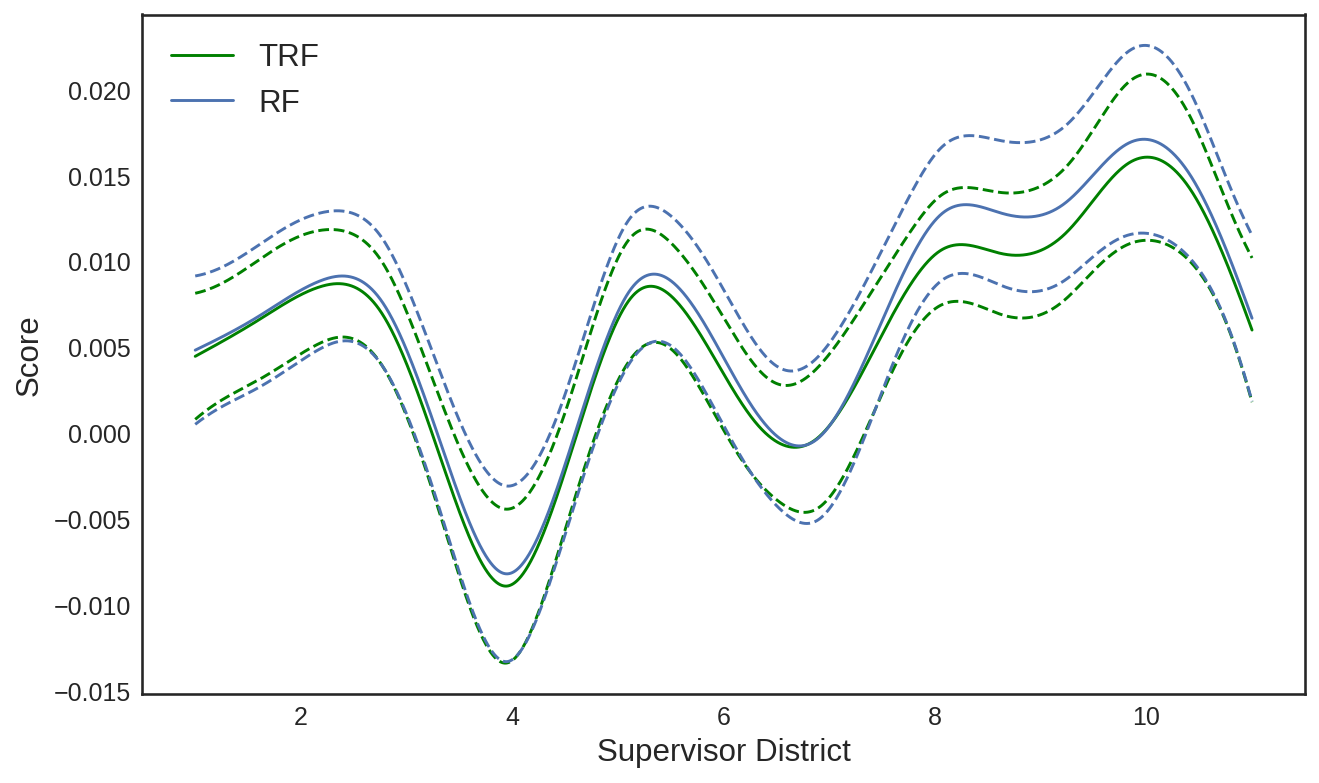

Number of Existing Stories
7


<Figure size 576x432 with 0 Axes>

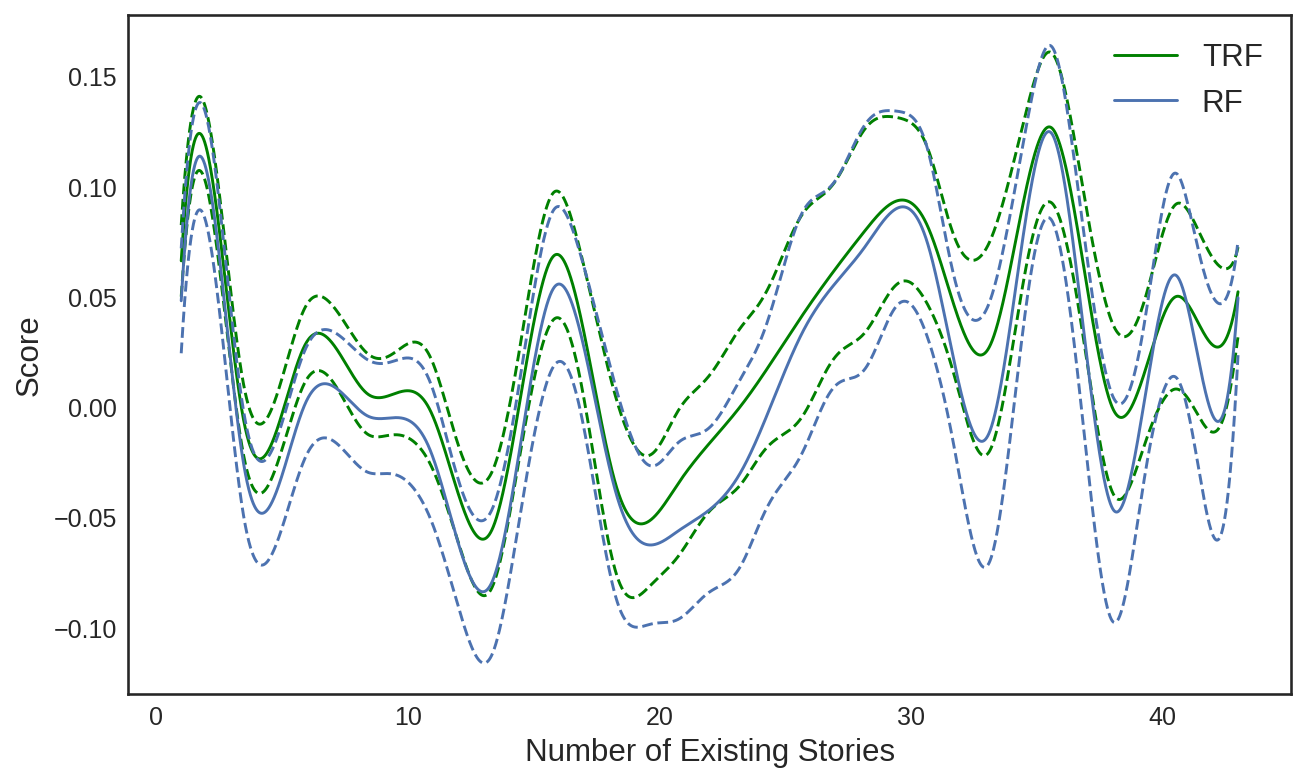

Estimated Cost
8


<Figure size 576x432 with 0 Axes>

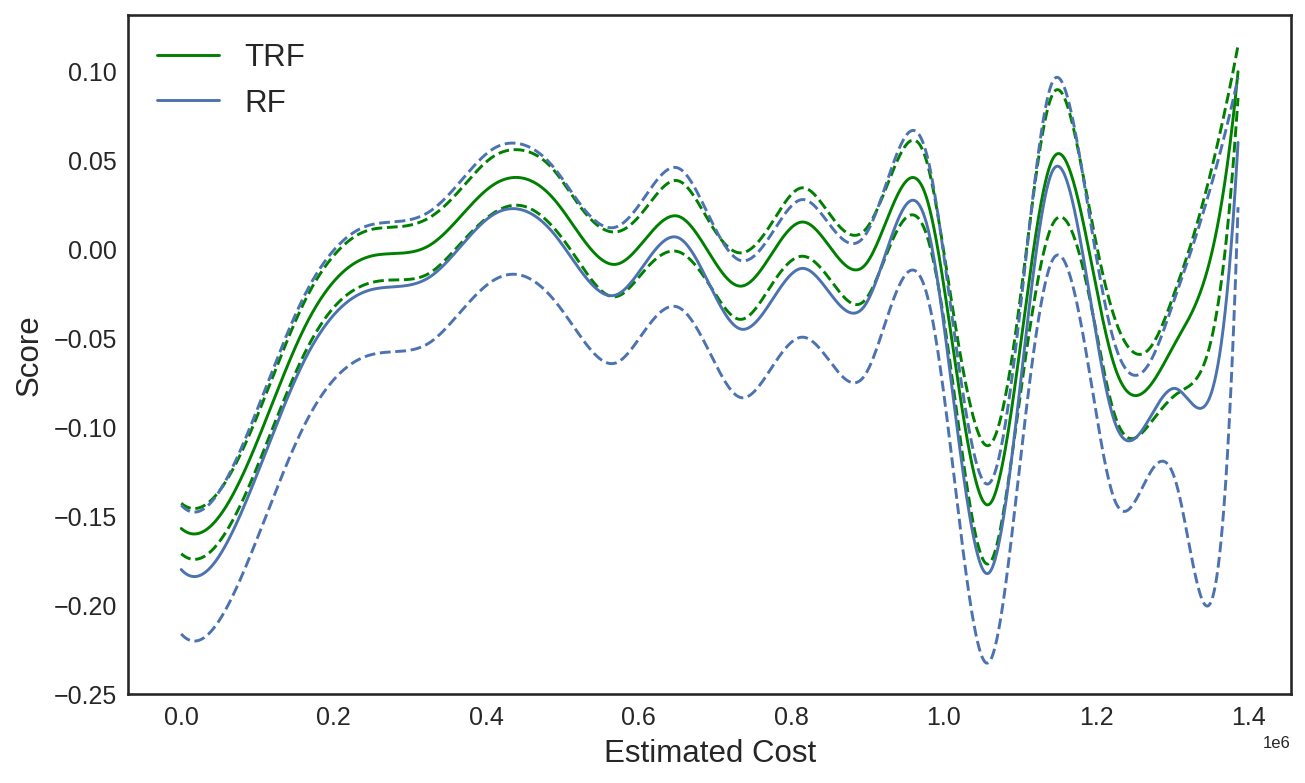

Number of Proposed Stories
9


<Figure size 576x432 with 0 Axes>

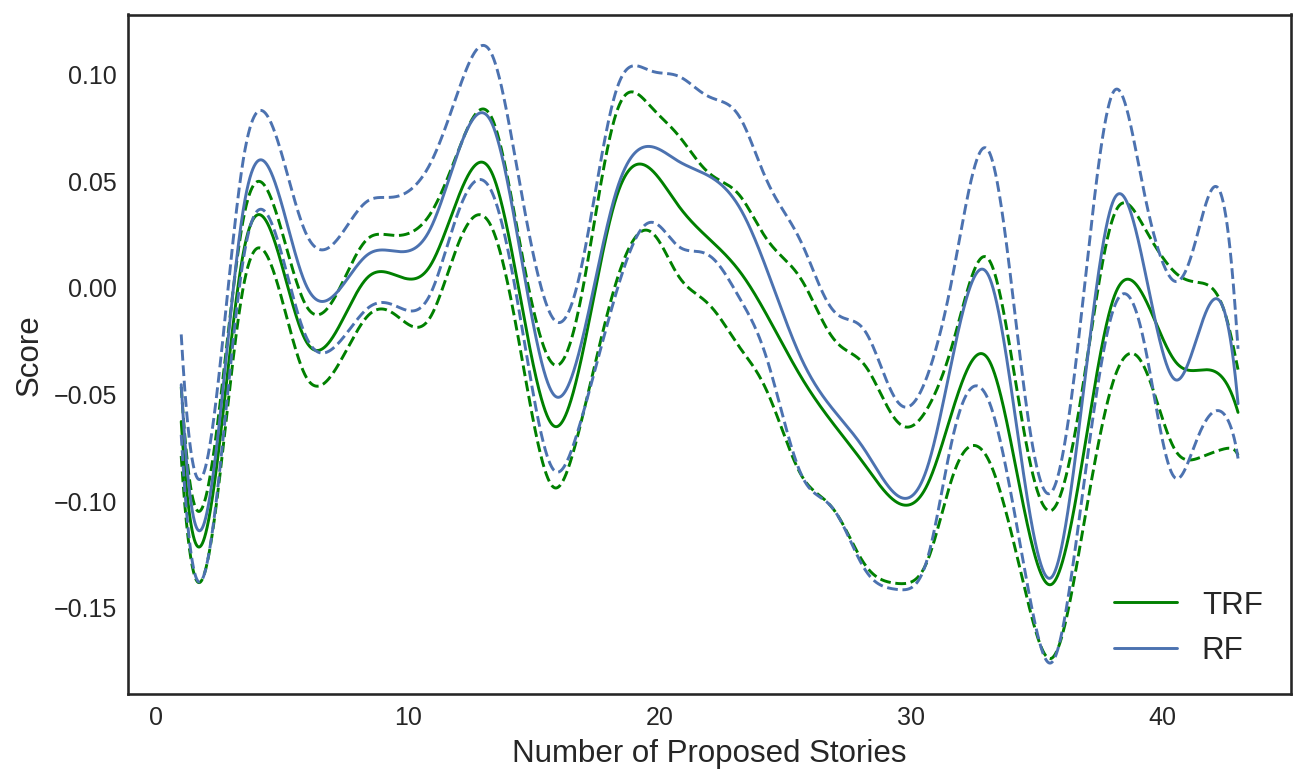

Proposed Units
11


<Figure size 576x432 with 0 Axes>

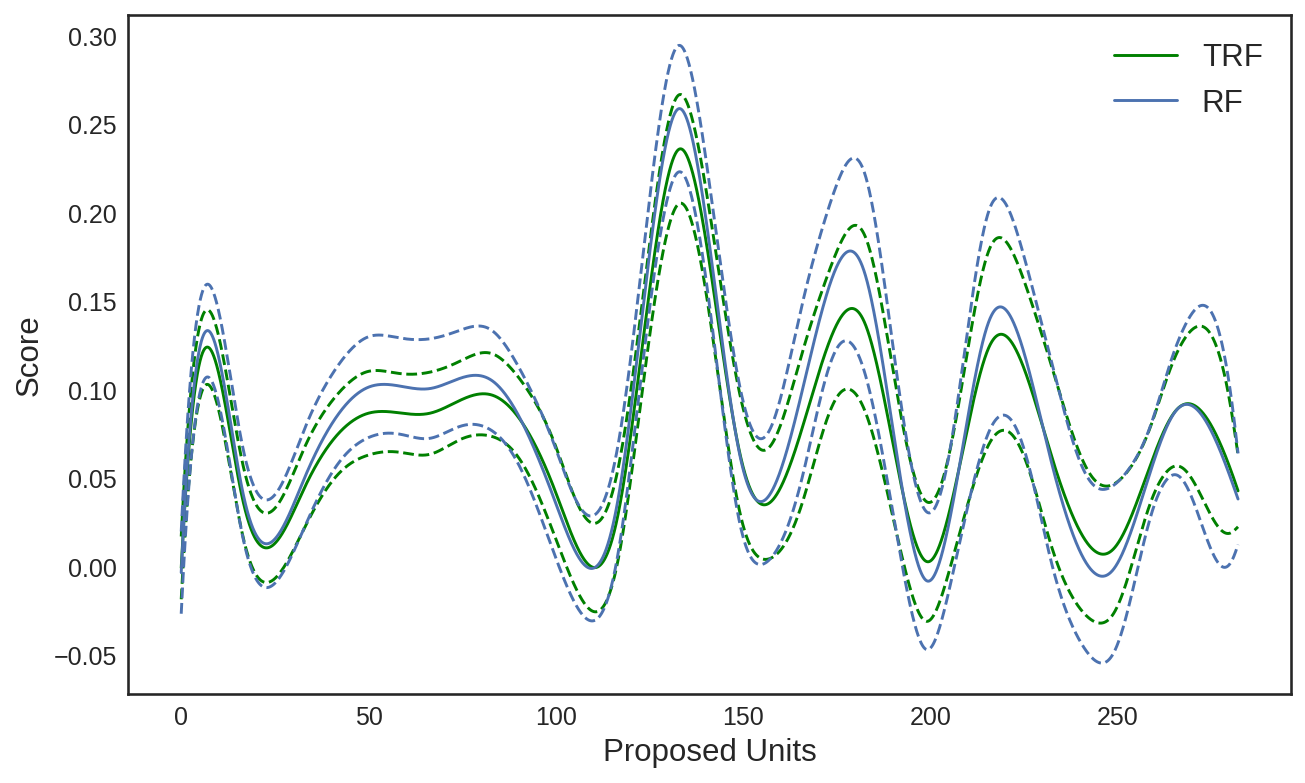

Existing Units
12


<Figure size 576x432 with 0 Axes>

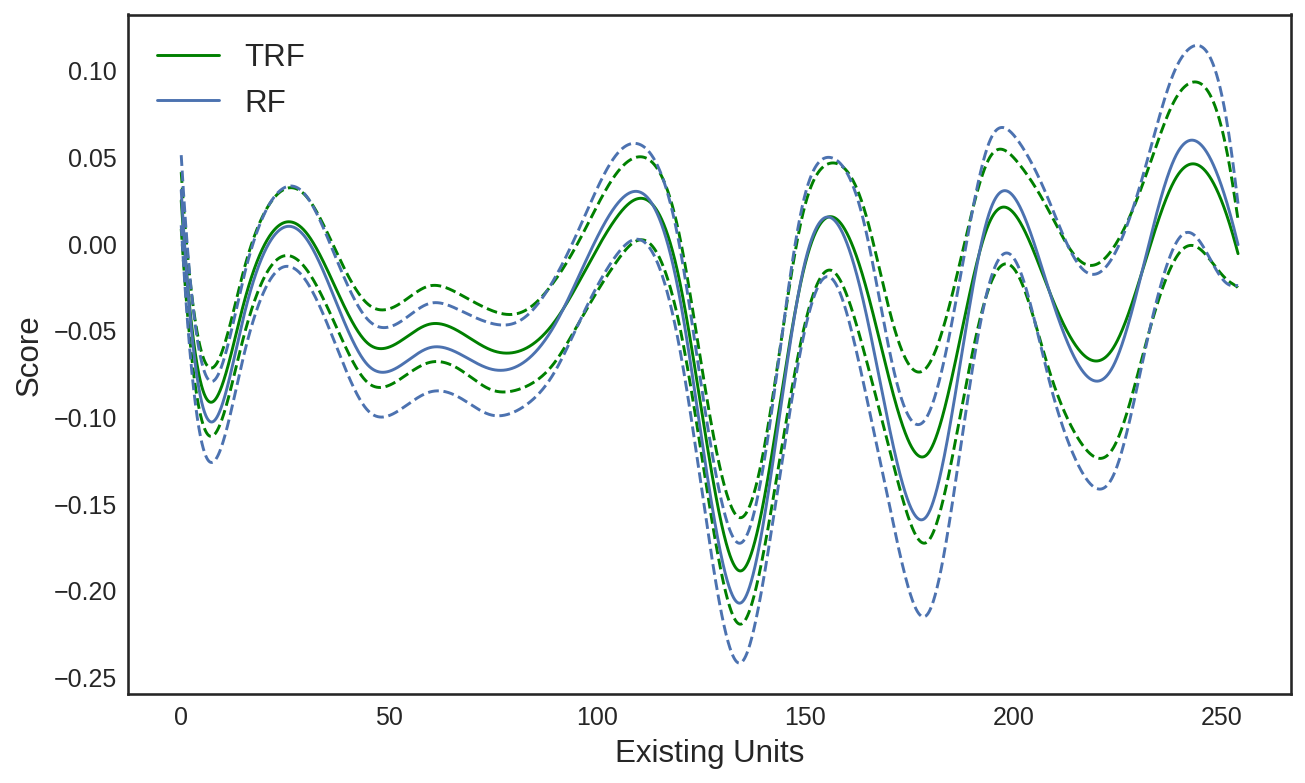

<Figure size 576x432 with 0 Axes>

In [131]:
for i, feat in enumerate(features):
    if feat not in numerical_features:
        continue
    print(feat)
    print(i)
    XX = gam_challenger.generate_X_grid(i, n=X_test.shape[0])
    ### Fix needed for this dataset
    XX[:, 5] = X_test.values[:, 5]
    pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    plt.plot(XX[:, i], pdep, c="green", label="TRF")
    plt.plot(XX[:, i], confi, c='green', ls='--')
    plt.ylabel("Score")
    plt.legend()

    ### Benchmark
    pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
    plt.plot(XX[:, i], pdep, color="#4c72b0", label="RF")
    plt.plot(XX[:, i], confi, c='#4c72b0', ls='--')
    plt.ylabel("Score", fontsize=15)
    plt.legend()

    plt.xlabel(feat, fontsize=15)

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.ylim([ymin, ymax])
    plt.legend(fontsize=15)
    plt.savefig("../images/{}_feature_impact_{}.eps".format(PREFIX, feat), format="eps")

    plt.show()
    plt.clf()

Existing Use


No handles with labels found to put in legend.


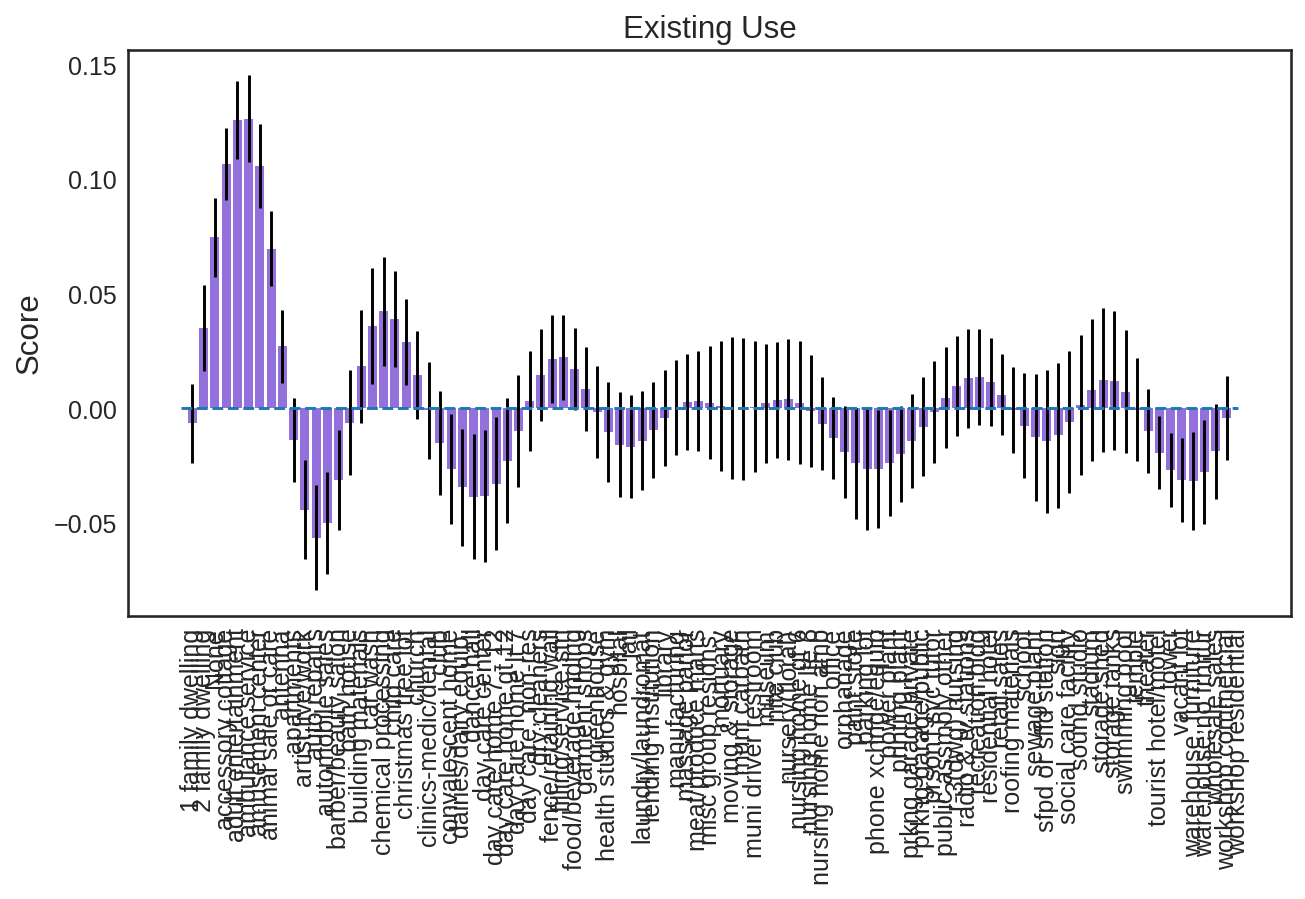

No handles with labels found to put in legend.


Street Suffix


<Figure size 576x432 with 0 Axes>

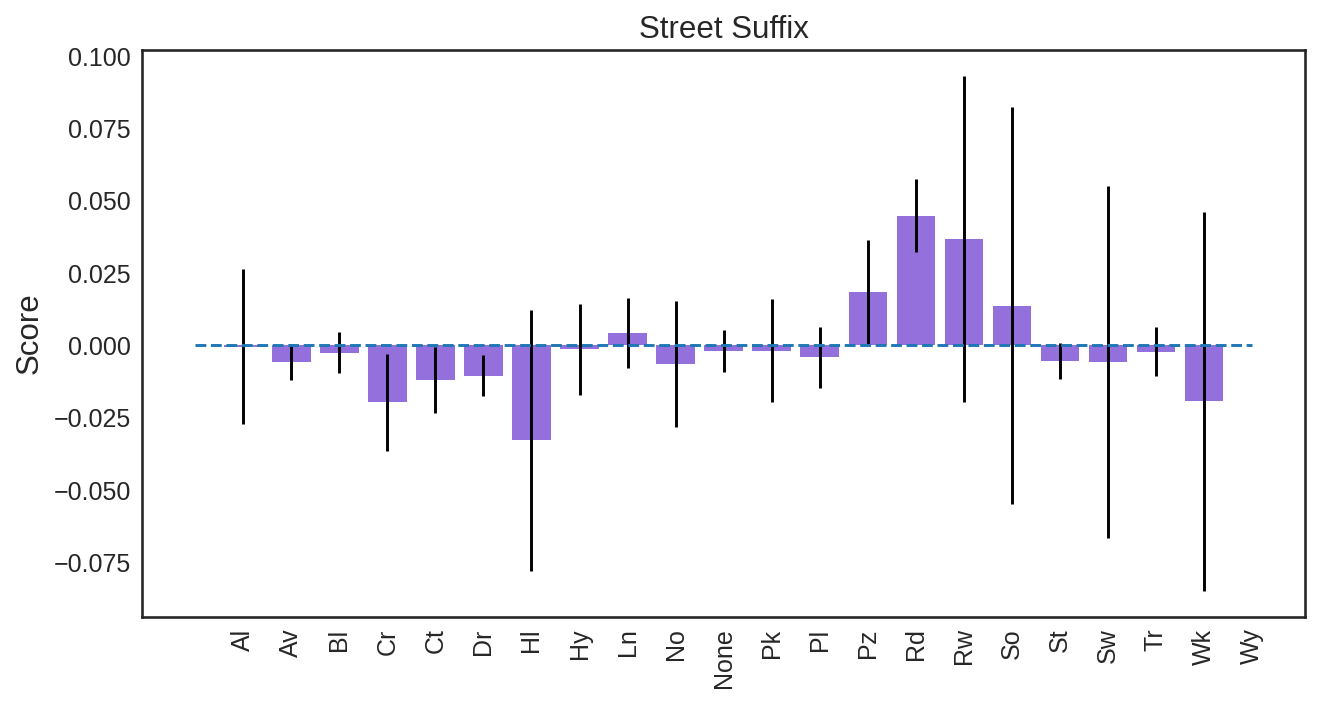

No handles with labels found to put in legend.


Unit Suffix
Fire Only Permit


<Figure size 576x432 with 0 Axes>

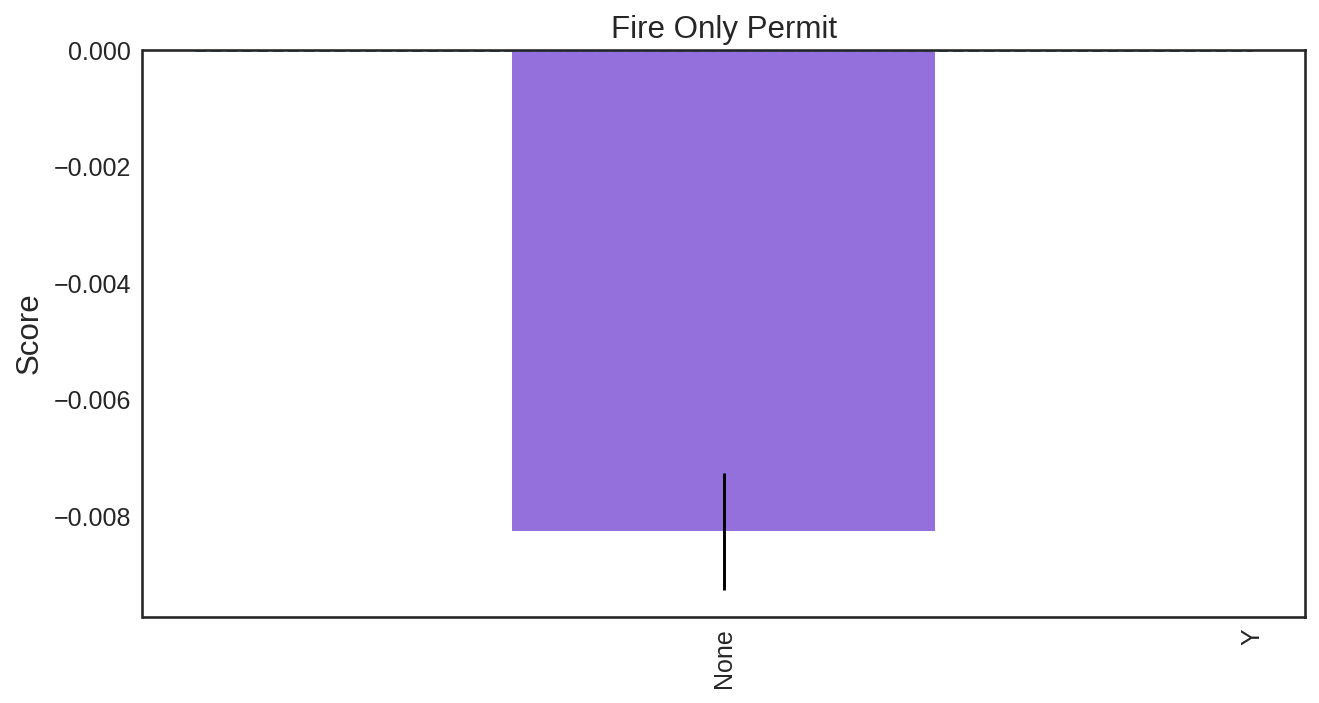

No handles with labels found to put in legend.


Neighborhoods - Analysis Boundaries


<Figure size 576x432 with 0 Axes>

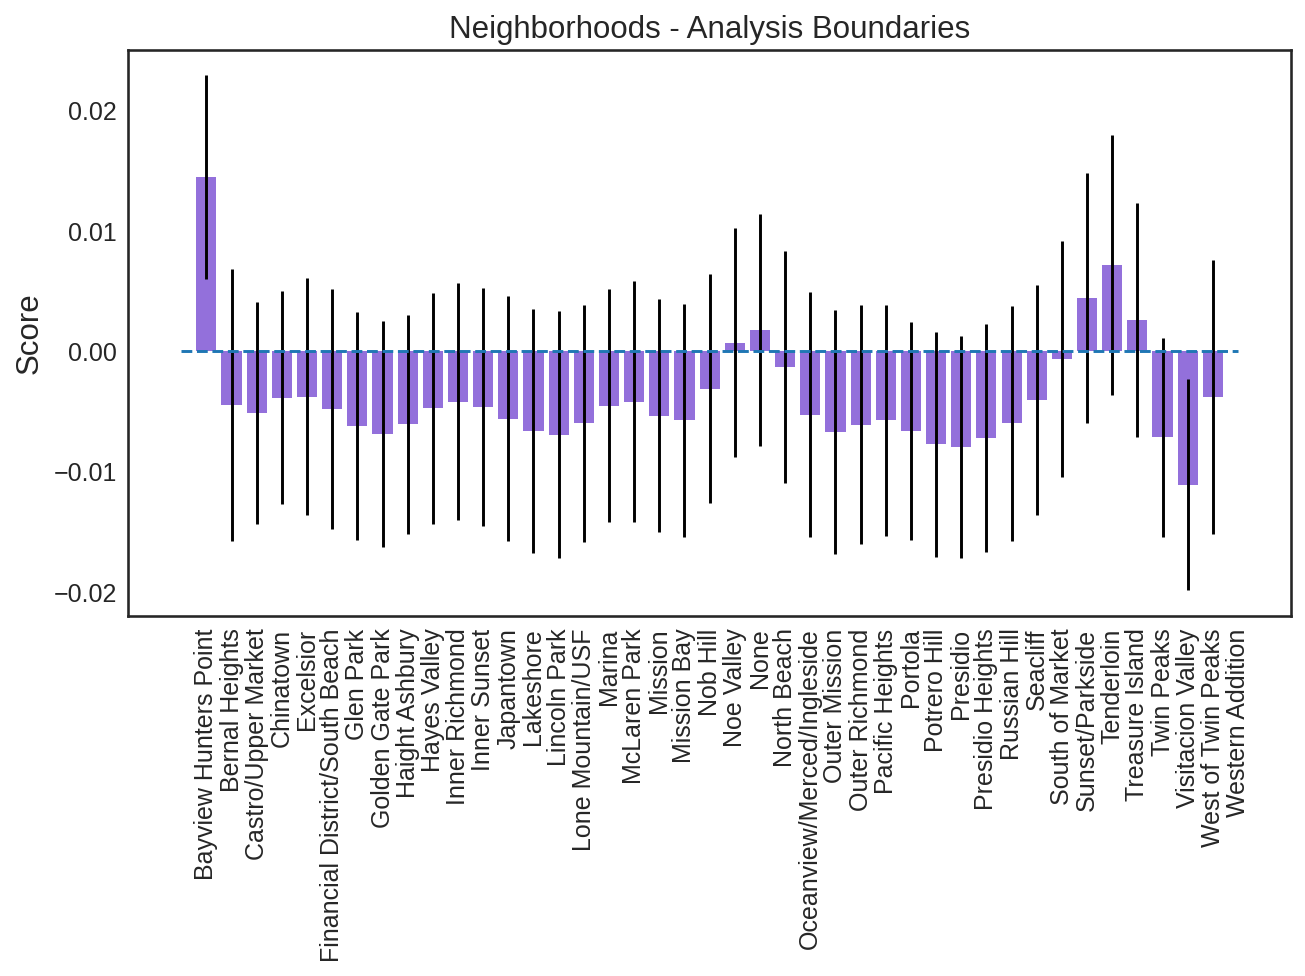

Proposed Use


No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

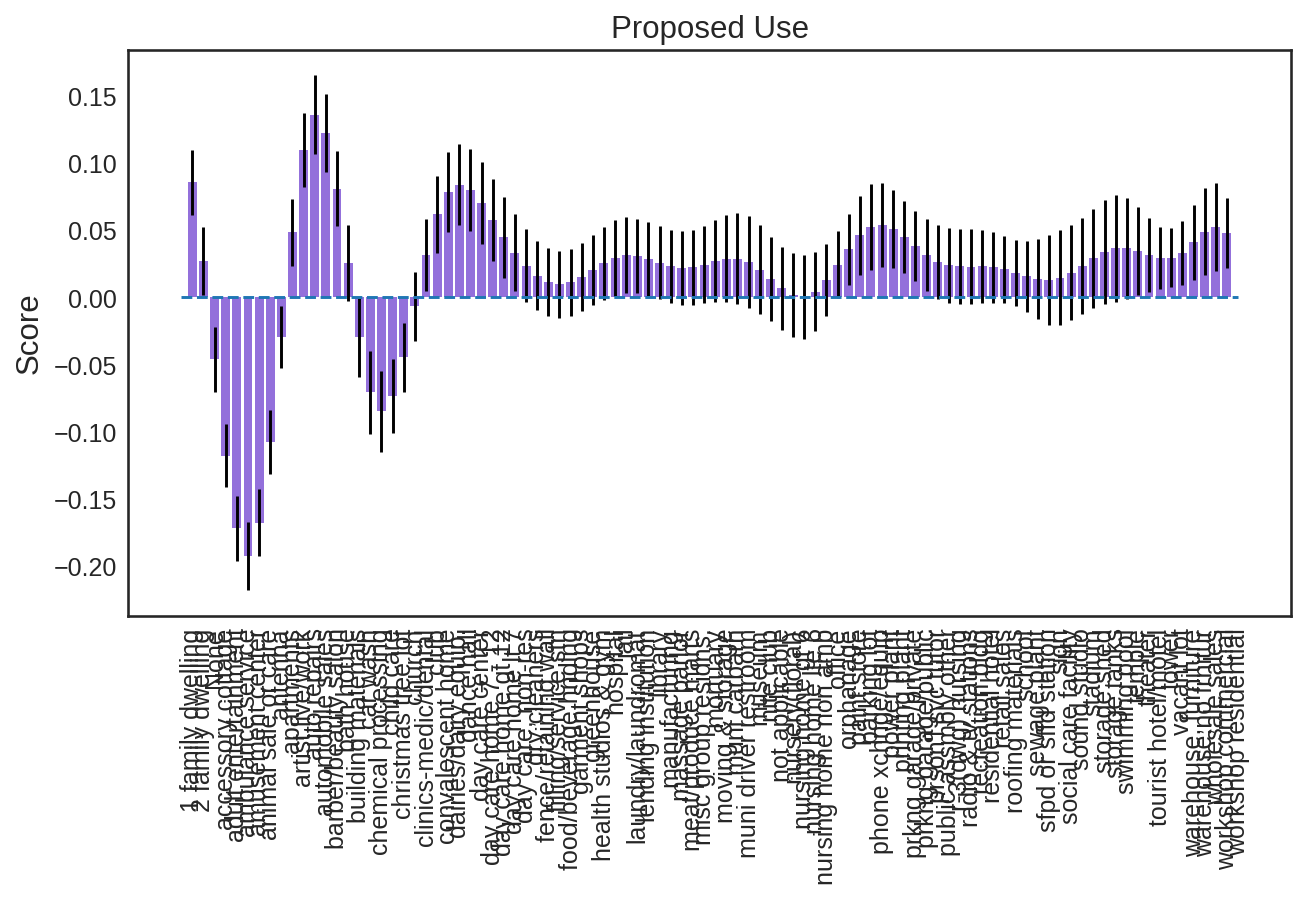

<Figure size 576x432 with 0 Axes>

In [132]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        try:
            mapping = encoder_mappings[feat]
            max_cat = np.max(list(mapping.keys()))
            if max_cat > 100:
                continue
            XX = np.copy(X_test)
            XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
            pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
            fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
            data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                                columns=[feat, "Mean Impact", "low", "high"])
            data["low"] = np.abs(data["low"] - data["Mean Impact"])
            data["high"] = np.abs(data["high"] - data["Mean Impact"])
            agg = data.groupby(feat).mean()

            impact_plot = plt.bar([i for i in range(len(agg))],
                                  agg["Mean Impact"],
                                  yerr=agg[["low", "high"]].values.transpose(),
                                  color="#9370DB",
                                  capsize=7)

            plt.title(feat, fontsize=15)
            plt.xticks([i for i in range(len(list(mapping.keys())))])
            ax.set_xticklabels(list(mapping.values()), rotation=90)
            plt.hlines(0.0, -1, max_cat, linestyles="dashed")
            plt.ylabel("Score", fontsize=15)

            ax.xaxis.set_tick_params(labelsize=12)
            ax.yaxis.set_tick_params(labelsize=12)
            xmin, xmax, ymin, ymax = plt.axis()
            plt.ylim([ymin, ymax])
            plt.legend(fontsize=15)
            plt.savefig("../images/{}_feature_impact_cat_{}.eps".format(PREFIX, feat), format="eps")

            plt.show()
            plt.clf()
        except:
            print("No plot for {}".format(feat))
plt.show()

Existing Use


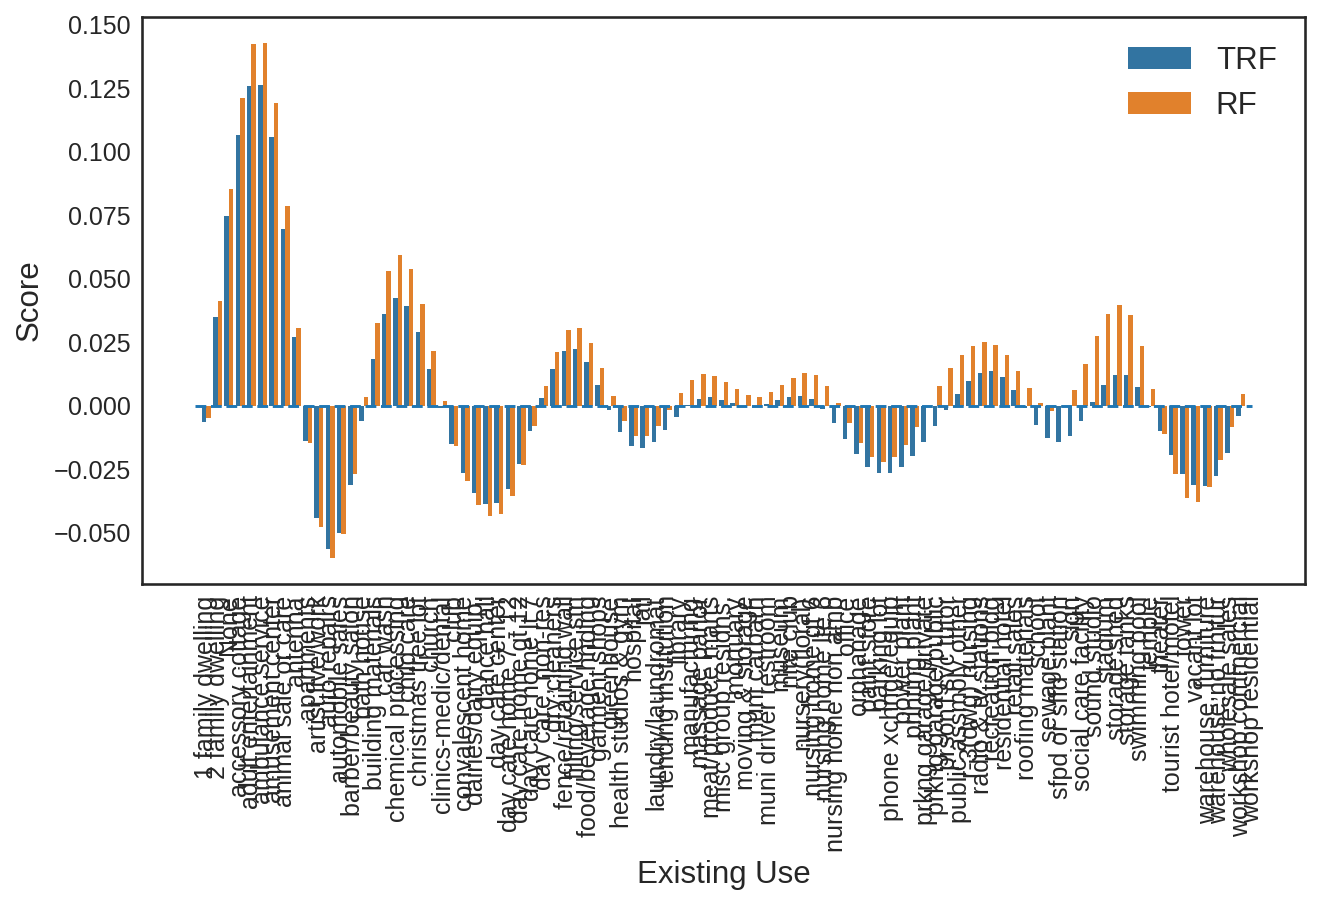

Street Suffix


<Figure size 576x432 with 0 Axes>

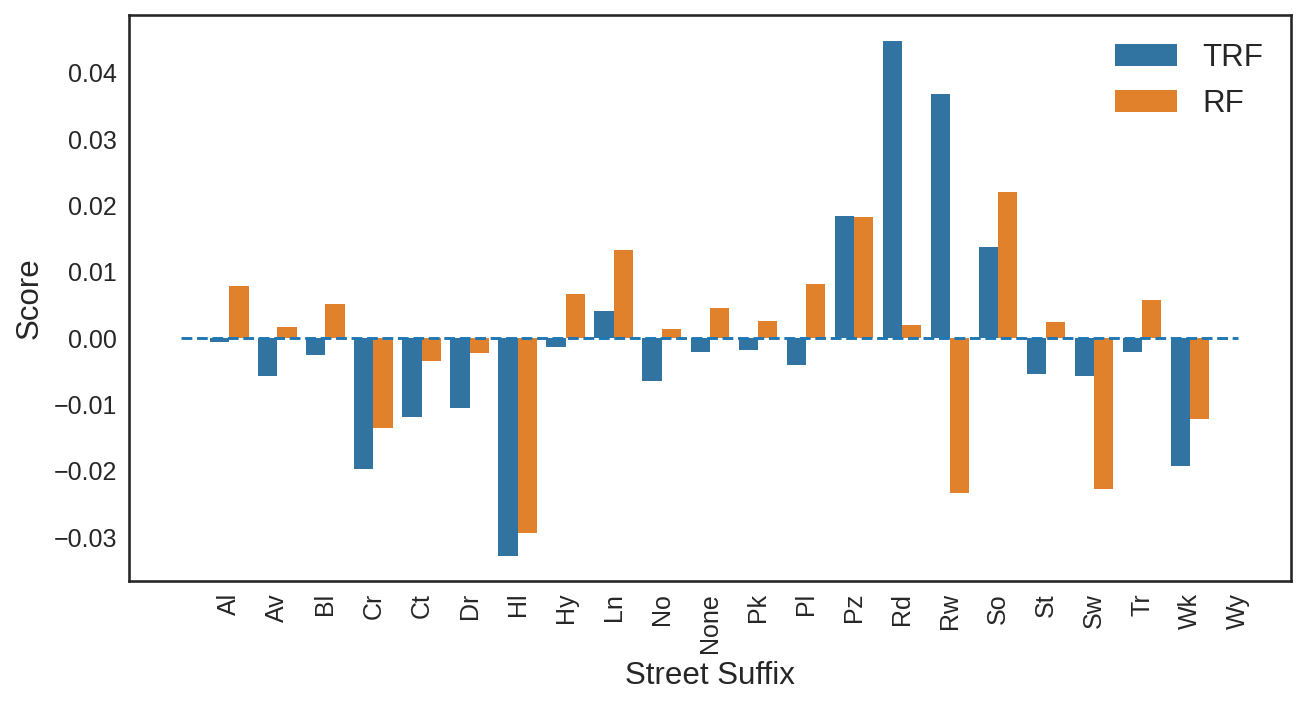

Unit Suffix
Fire Only Permit


<Figure size 576x432 with 0 Axes>

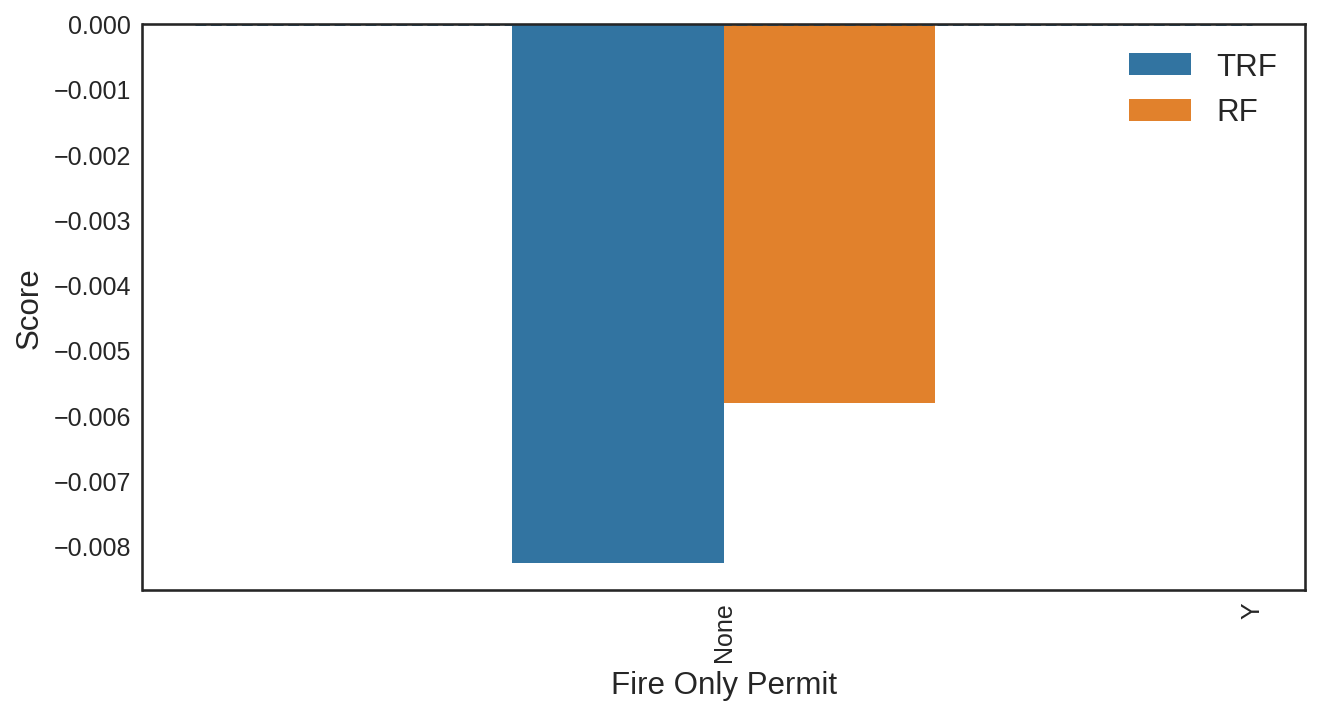

Neighborhoods - Analysis Boundaries


<Figure size 576x432 with 0 Axes>

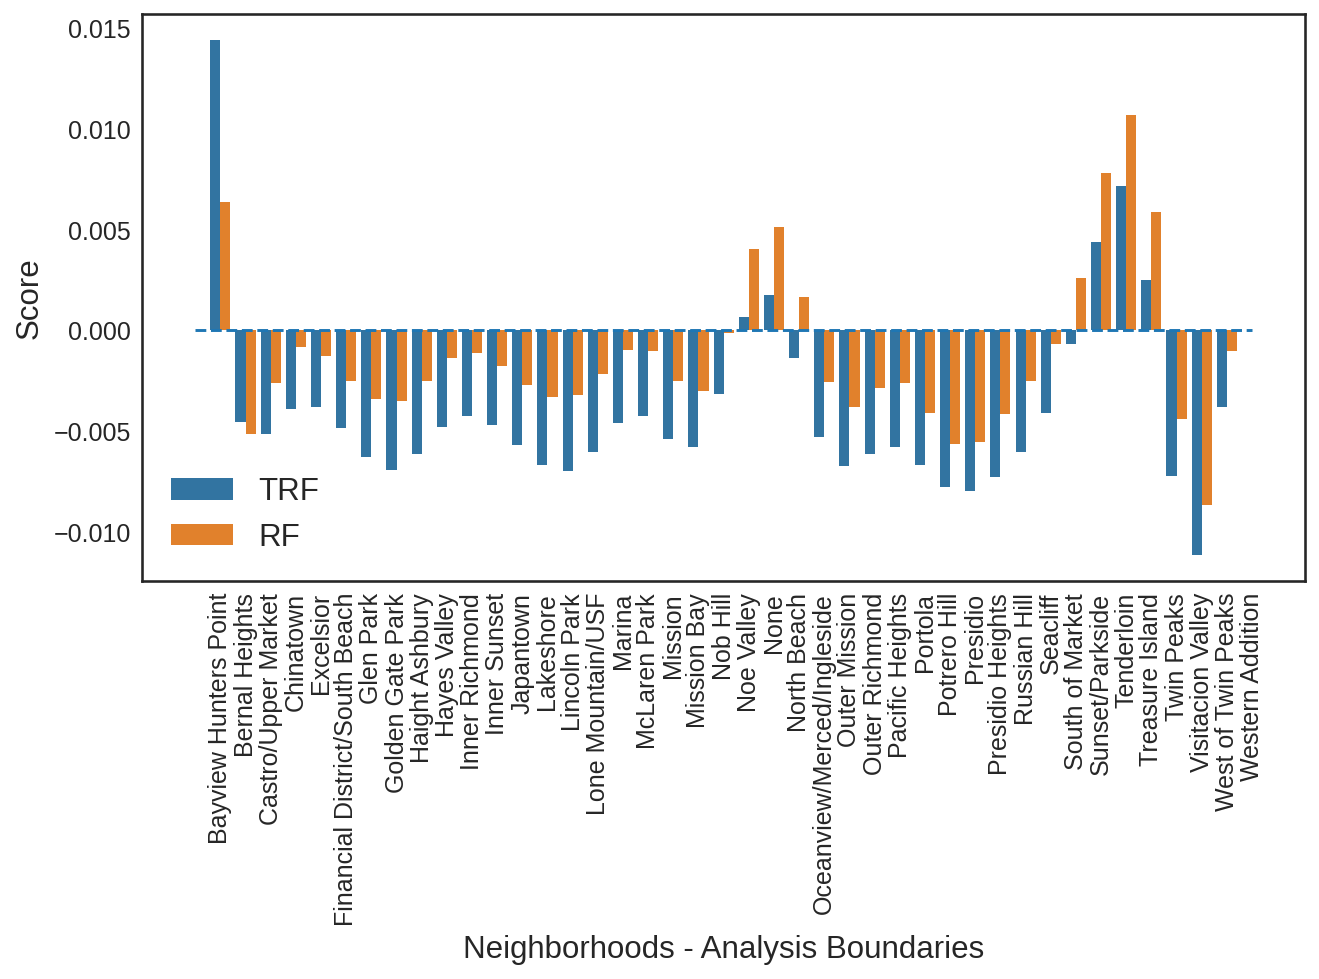

Proposed Use


<Figure size 576x432 with 0 Axes>

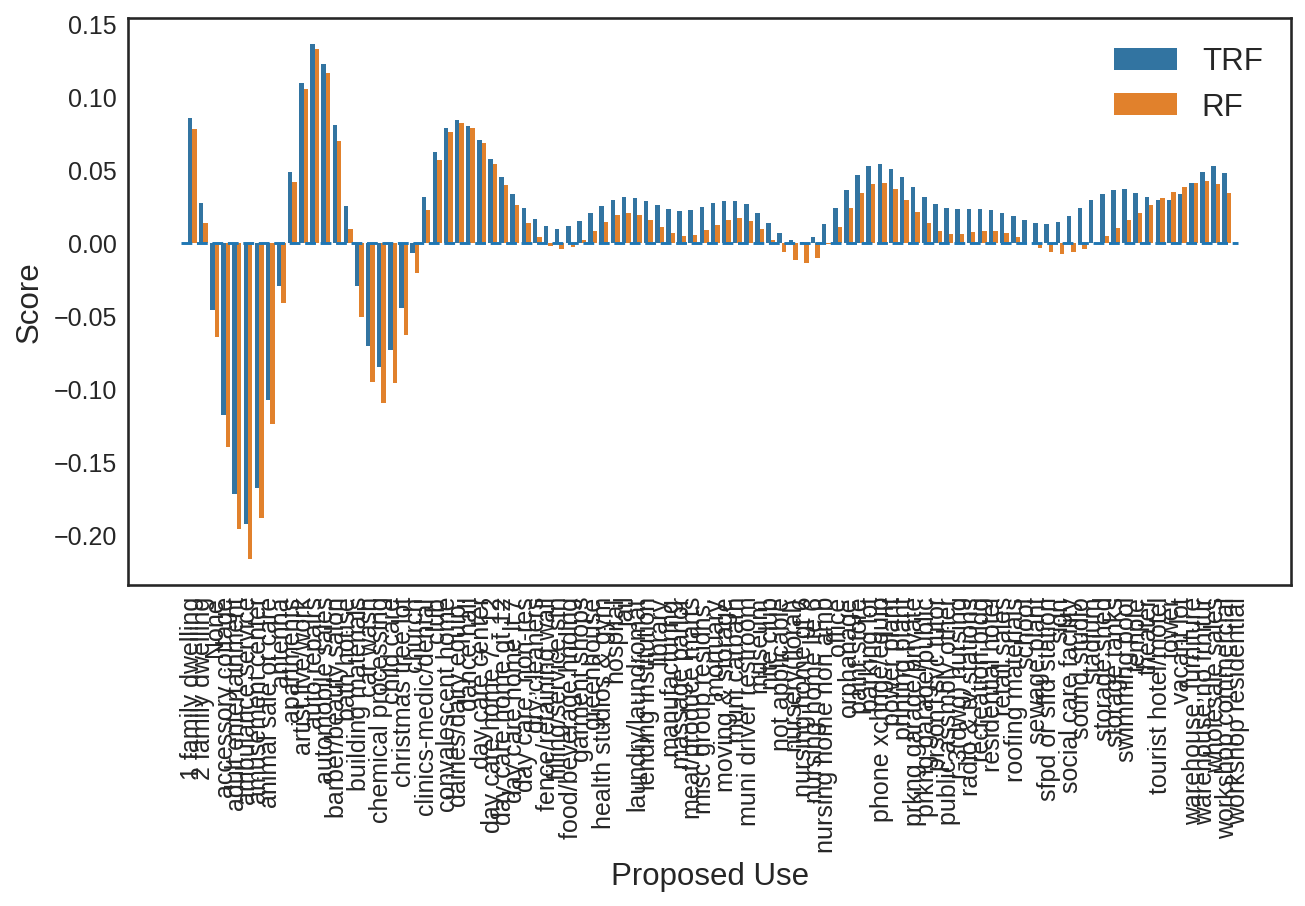

<Figure size 576x432 with 0 Axes>

In [133]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        ### Challenger
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        data["model"] = "TRF"
        agg = data.groupby(feat).mean()


        ### Benchmark
        pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
        data_benchmark = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data_benchmark["low"] = np.abs(data_benchmark["low"] - data_benchmark["Mean Impact"])
        data_benchmark["high"] = np.abs(data_benchmark["high"] - data_benchmark["Mean Impact"])
        data_benchmark["model"] = "RF"
        
        data = pd.concat([data, data_benchmark])
        agg = data.groupby(feat).mean()
        
        sns.barplot(data=data, x=feat, y="Mean Impact", hue="model")


        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)
        
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.xlabel(feat, fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_comparison_{}.eps".format(PREFIX, feat), format="eps")
        
        plt.show()
        plt.clf()

## Minimum samples by period effect

In [134]:
target = TARGET
min_sample_periods_values = [1, 5, 10, 20, 50, 100, 250, 500]

In [135]:
min_sample_knob = {}
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=min_sample_periods,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)
    
    model_split_time.fit(train[features + [TIME_COLUMN]], train[target])
    out_of_time["time_split_prediction"] = model_split_time.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model_split_time.predict(train[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model_split_time.predict(test[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

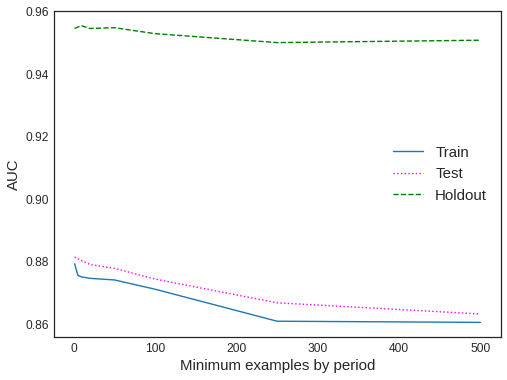

In [136]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole.eps".format(PREFIX), format="eps")
plt.show()

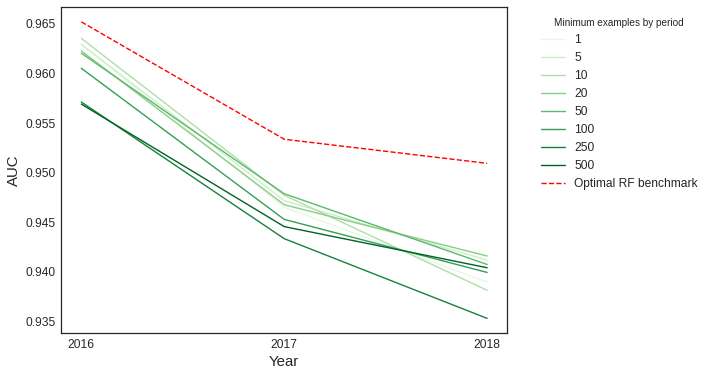

In [137]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [138]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

training_segments = train[TIME_COLUMN].nunique()
for min_sample_periods in min_sample_periods_values:

    model = tuned_rf
    model.set_params(min_samples_leaf=training_segments * min_sample_periods)
    
    
    model.fit(train[features],
              train[TARGET])
     
    out_of_time["time_split_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model.predict(train[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model.predict(test[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

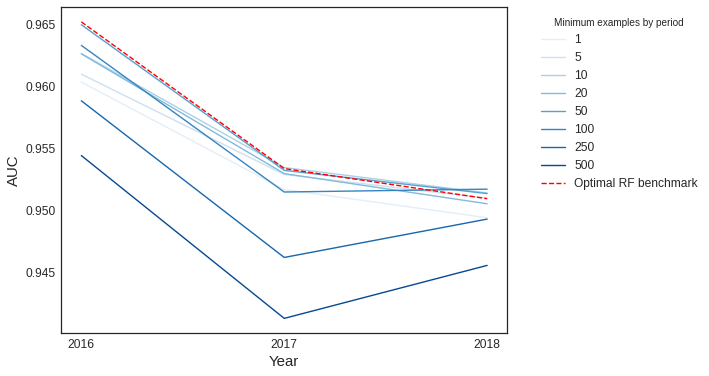

In [139]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

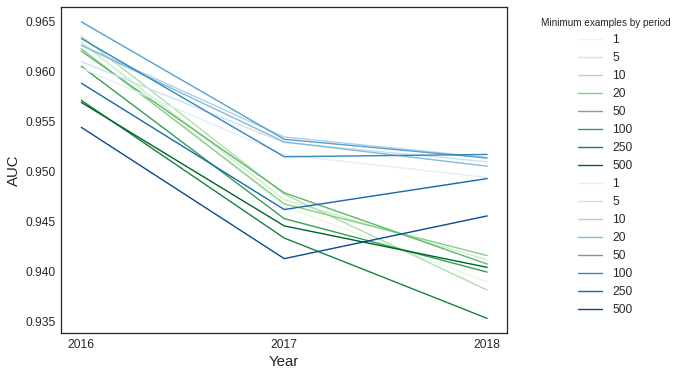

In [140]:
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

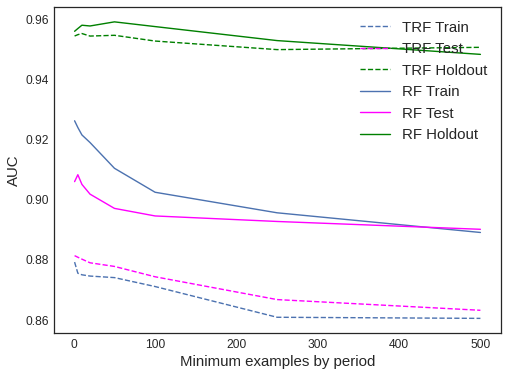

In [141]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

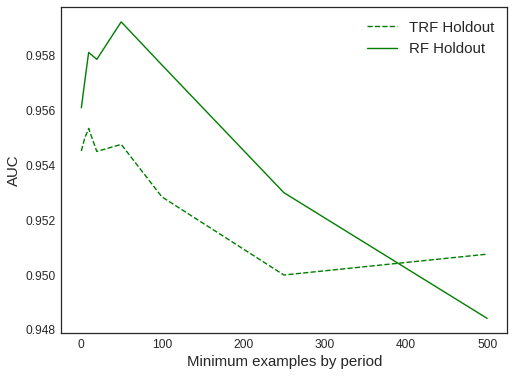

In [142]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

## Domain classifier

In [143]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [144]:
domain_data = pd.concat([train, test, out_of_time])

In [145]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [146]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

In [147]:
domain_model = tuned_domain_rf

In [148]:
domain_model.fit(train_domain[features], train_domain["domain"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=9, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=124, verbose=0, warm_start=False)

In [149]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [150]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.6058370899546388

## Other optimization design for the RF

In [151]:
last_time_segment_in_train = np.max(in_time[TIME_COLUMN].unique())
last_time_segment_in_train

2015

In [152]:
posfix = str(last_time_segment_in_train)

In [153]:
new_train = in_time[in_time["Year"] < last_time_segment_in_train]
new_validation = in_time[in_time["Year"] == last_time_segment_in_train]

In [154]:
clf1 = setup(new_train[features + [TARGET]], target="target",
             test_data=new_validation,
             session_id=44,
             log_experiment=False,
             experiment_name="{}_opt1".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [155]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=240,
                       n_jobs=-1, oob_score=False, random_state=44, verbose=0,
                       warm_start=False)

In [156]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [157]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [158]:
clf1 = setup(new_train[features + [TARGET]], target="target",
             test_data=new_validation,
             session_id=22,
             log_experiment=False,
             experiment_name="{}_opt2".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [159]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

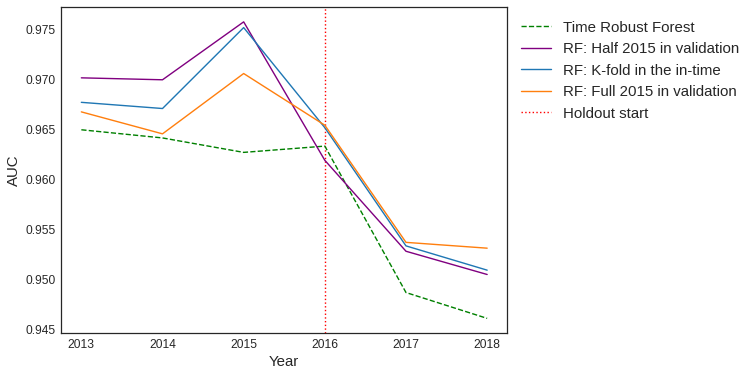

In [160]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_half_{}".format(posfix)])).plot(label="RF: Half {} in validation".format(posfix), 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_{}".format(posfix)])).plot(label="RF: Full {} in validation".format(posfix), ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_performance_proof.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()
